# Intraday Mean Reversion Trading on Indian Equity Markets

Import standard libraries

In [1]:
from IPython.core.display_functions import display
from types import NoneType
from typing import Any
from collections.abc import (
    Callable,
    Iterable,
    Iterator,
    Collection,
    Sequence,
    Mapping,
    MutableMapping,
)
from collections import namedtuple, defaultdict
import datetime
from pathlib import Path
import itertools
import functools
import sortedcontainers
import matplotlib
import matplotlib.dates
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy
import sklearn as sk
import sklearn.pipeline
import sklearn.model_selection
import sklearn.utils

Flags / global config. Please modify them as needed.

In [2]:
BASEDIR: Path = Path(r"/home/arthur/Downloads/MScFE/capstone")
USELATEX = True
SKLCACHE = 4096  # cache size in MB to use with sklearn
NJOBS = 6
RANDSEED = None
sns.set_context("paper")
sns.set_palette("deep")

## Utilities and other python helper functions

Use latex for plotting to allow equations and to maintain the same typesetting
as the paper. You will need to have latex installed.

In [3]:
if USELATEX:
    import re

    # from https://stackoverflow.com/a/25875504
    LATEXESCAPE = {
        "&": r"\&",
        "%": r"\%",
        "$": r"\$",
        "#": r"\#",
        "_": r"\_",
        "{": r"\{",
        "}": r"\}",
        "~": r"\textasciitilde{}",
        "^": r"\^{}",
        "\\": r"\textbackslash{}",
        "<": r"\textless{}",
        ">": r"\textgreater{}",
    }
    regex = re.compile(
        "|".join(
            re.escape(str(key))
            for key in sorted(LATEXESCAPE.keys(), key=lambda item: -len(item))
        )
    )

    def latexEscape(text: str) -> str:
        """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
        """
        return regex.sub(lambda match: LATEXESCAPE[match.group()], text)

    def latexTextSC(text: str) -> str:
        return r"\textsc{" + text + r"}"

    plt.rcParams.update(
        {"text.usetex": True, "font.family": "serif", "font.sans-serif": "XCharter"}
    )
else:

    def latexEscape(text: str) -> str:
        return text

    def latexTextSC(text: str) -> str:
        return text.upper()


def getattrrec(obj, attr, *args):
    from functools import reduce

    return reduce(lambda o, a: getattr(o, a, *args), (obj, *attr.split(".")))

Helper function for multiprocessing.

In [4]:
async def concurrent_map_fold(
    arr: Iterable, mapf: Callable, foldf: Callable, /, *, acc=None
):
    """Maps a function in parallel and folds the resulting sequence as and when
    they return."""
    import asyncio

    for coro in asyncio.as_completed([asyncio.to_thread(mapf, a) for a in arr]):
        res = await coro
        acc = res if acc is None else foldf(acc, res)
    return acc

Helper functions for Pandas.

In [5]:
def mapNumpyOverDataFrame(
    f: Callable[..., np.ndarray], df: pd.DataFrame, /, *, keepColNames=True
) -> pd.DataFrame:
    return pd.DataFrame(
        f(df), index=df.index, columns=df.columns if keepColNames else None
    )


def mapNumpyDataFrameToSeries(
    f: Callable[..., np.ndarray], df: pd.DataFrame, /
) -> pd.Series:
    result = mapNumpyOverDataFrame(f, df, keepColNames=False)
    assert len(result.columns) == 1
    return result.iloc(axis=1)[0]


def applyLabelMap(
    labelMap: dict[str, str], data: Iterable[pd.Series | pd.DataFrame]
) -> None:
    for s in data:
        if isinstance(s, pd.Series):
            s.name = labelMap[s.name]  # type: ignore
        elif isinstance(s, pd.DataFrame):
            s.columns = [labelMap[col] for col in s.columns]


def computeMultiple(
    f: Callable[..., pd.Series],
    *args,
    multipleArgs: Iterable[
        Iterable | Mapping[str, Any] | tuple[Iterable, Mapping[str, Any]]
    ] = [],
    prettyLabelMap: MutableMapping[str, str] | NoneType = None,
    **kwargs,
):
    results = []
    for mArg in multipleArgs:
        if isinstance(mArg, tuple):
            margs, mkwargs = mArg
        elif isinstance(mArg, Mapping):
            margs, mkwargs = [], mArg
        else:
            margs, mkwargs = mArg, {}
        results.append(
            f(*args, *margs, **kwargs, **mkwargs, prettyLabelMap=prettyLabelMap)
        )
    if not results:
        return pd.DataFrame()
    return results[0].to_frame().join(results[1:], how="outer")


def regexApplyCols(
    data: pd.DataFrame,
    weights: Mapping[str, float | Callable[[pd.Series], pd.Series]],
    /,
) -> pd.DataFrame:
    import re

    data = data.copy(deep=False)  # this is suffice to not modify the original
    for regex, w in weights.items():
        colMatches = [col for col in data.columns if re.fullmatch(regex, col)]
        if not colMatches:
            raise ValueError(f"regex {regex} matches no columns")
        if isinstance(w, Callable):
            data[colMatches] = data[colMatches].apply(w, axis=0)
        else:
            data[colMatches] = data[colMatches] * w
    return data

Helper functions for Pandas.

In [6]:
def drawMultipleYAxes(
    plotters: Iterable[Callable], /, *, ax: matplotlib.axes.Axes
) -> list:
    thisAx = ax
    axPrev = ax
    axBBoxXMax = 0
    lines = []
    for idx, plotter in enumerate(plotters):
        if idx > 0:
            if idx == 1:
                axBBoxXMax = ax.get_tightbbox().xmax  # type: ignore
            thisAx = ax.twinx()
            # move spine out of the previous bounding box
            thisAx.spines.right.set_position(
                ("outward", axPrev.get_tightbbox().xmax - axBBoxXMax)  # type: ignore
            )
        lines.extend(plotter(thisAx))
        axPrev = thisAx
    return lines


def plotDataframeWSeperateYAxes(
    df: pd.DataFrame, /, *, figsize=None, **plotkwargs
) -> matplotlib.figure.Figure:
    def plotter(idx, col):
        def f(ax):
            if idx > 0:
                ax.tick_params(axis="y", colors=f"C{idx}")
            line = ax.plot(
                df.index,
                df[col],
                color=f"C{idx}",
                label=col + (" (right)" if idx >= 1 else ""),
                **plotkwargs,
            )
            return line

        return f

    fig, axis = plt.subplots(figsize=figsize)
    lines = drawMultipleYAxes(
        (plotter(idx, col) for idx, col in enumerate(df.columns)), ax=axis
    )
    axis.legend(handles=lines)
    if df.index.name:
        axis.set_xlabel(df.index.name)
    return fig

Helper functions for Pandas intervals.

In [7]:
def closeStr(leftClosed: bool, rightClosed: bool) -> str:
    if leftClosed:
        return "both" if rightClosed else "left"
    else:
        return "right" if rightClosed else "neither"


def largestIntervalLeft(intervals: Iterable[pd.Interval]) -> tuple:
    interval = next(intIt := iter(intervals))
    largest = interval.left
    closed = interval.closed_left
    for interval in intIt:
        if interval.left > largest:
            largest = interval.left
            closed = interval.closed_left
        elif interval.left == largest:
            closed = closed and interval.closed_left
    return (largest, closed)


def smallestIntervalRight(intervals: Iterable[pd.Interval]) -> tuple:
    interval = next(intIt := iter(intervals))
    smallest = interval.right
    closed = interval.closed_right
    for interval in intIt:
        if interval.right < smallest:
            smallest = interval.right
            closed = interval.closed_right
        elif interval.right == smallest:
            closed = closed and interval.closed_right
    return (smallest, closed)


def intervalIntersection(
    aIntervals: Iterable[pd.Interval], bIntervals: Iterable[pd.Interval]
) -> list[pd.Interval]:
    intersections = []
    aArr, bArr = sorted(aIntervals), sorted(bIntervals)
    while aArr and bArr:
        a = aArr.pop()
        b = bArr.pop()
        while aArr and a.overlaps(aArr[-1]):
            other = aArr.pop()
            a = pd.Interval(
                left=other.left,
                right=a.right,
                closed=closeStr(other.closed_left, a.closed_right),  # type: ignore
            )
        while bArr and b.overlaps(bArr[-1]):
            other = bArr.pop()
            b = pd.Interval(
                left=other.left,
                right=b.right,
                closed=closeStr(other.closed_left, b.closed_right),  # type: ignore
            )
        if a.overlaps(b):
            lVal, lClosed = largestIntervalLeft([a, b])
            rVal, rClosed = smallestIntervalRight([a, b])
            intersections.append(
                pd.Interval(left=lVal, right=rVal, closed=closeStr(lClosed, rClosed))  # type: ignore
            )
        if a < b:
            aArr.append(a)
        else:
            bArr.append(b)
    intersections.reverse()
    return intersections


def intervalDifference(
    aIntervals: Iterable[pd.Interval], bIntervals: Iterable[pd.Interval]
) -> list[pd.Interval]:
    differences = []
    aArr, bArr = sorted(aIntervals), sorted(bIntervals)
    while aArr and bArr:
        a = aArr.pop()
        b = bArr.pop()
        while aArr and a.overlaps(aArr[-1]):
            other = aArr.pop()
            a = pd.Interval(
                left=other.left,
                right=a.right,
                closed=closeStr(other.closed_left, a.closed_right),  # type: ignore
            )
        while bArr and b.overlaps(bArr[-1]):
            other = bArr.pop()
            b = pd.Interval(
                left=other.left,
                right=b.right,
                closed=closeStr(other.closed_left, b.closed_right),  # type: ignore
            )
        if b.right < a.right or (
            a.right == b.right and a.closed_right and b.open_right
        ):  # a is sticking out
            if a.overlaps(b):
                differences.append(
                    pd.Interval(
                        left=b.right,
                        right=a.right,
                        closed=closeStr(b.open_right, a.closed_right),  # type: ignore
                    )
                )
                if a < b:
                    aArr.append(
                        pd.Interval(
                            left=a.left,
                            right=b.left,
                            closed=closeStr(a.closed_left, b.open_left),  # type: ignore
                        )
                    )
                elif a > b:
                    bArr.append(b)
            else:
                differences.append(a)
                bArr.append(b)
        else:
            if a.overlaps(b):
                if a < b:
                    aArr.append(
                        pd.Interval(
                            left=a.left,
                            right=b.left,
                            closed=closeStr(a.closed_left, b.open_left),  # type: ignore
                        )
                    )
                else:
                    bArr.append(b)
            else:
                aArr.append(a)
    aArr.extend(reversed(differences))
    return aArr


def coalesceIntervals(intervals: Iterable[pd.Interval]) -> set[pd.Interval]:
    def joinOverlappingIntervals(intA: pd.Interval, intB: pd.Interval) -> pd.Interval:
        if intA.left < intB.left:
            leftTime = intA.left
            leftClosed = intA.closed_left
        elif intA.left == intB.left:
            leftTime = intA.left
            leftClosed = intA.closed_left or intB.closed_left
        else:
            leftTime = intB.left
            leftClosed = intB.closed_left
        if intA.right > intB.right:
            rightTime = intA.right
            rightClosed = intA.closed_right
        elif intA.right == intB.right:
            rightTime = intA.right
            rightClosed = intA.closed_right or intB.closed_right
        else:
            rightTime = intB.right
            rightClosed = intB.closed_right
        return pd.Interval(
            left=leftTime,
            right=rightTime,
            closed=closeStr(leftClosed, rightClosed),  # type: ignore
        )

    aggIntervals = set()
    for interval in intervals:
        for aggInterval in list(aggIntervals):
            if any(
                [
                    interval.overlaps(aggInterval),
                    interval.right == aggInterval.left
                    and (interval.closed_right or aggInterval.closed_left),
                    aggInterval.right == interval.left
                    and (aggInterval.closed_right or interval.closed_left),
                ]
            ):
                aggIntervals.remove(aggInterval)
                interval = joinOverlappingIntervals(interval, aggInterval)
        aggIntervals.add(interval)
    return aggIntervals

Helper functions for scikit-learn.

In [8]:
def plotCVMetrics(
    cvmodel,
    /,
    *,
    figsize=None,
    showparams: bool | Iterable[str] = False,
    showindex: bool = True,
    showrank: bool = True,
) -> matplotlib.figure.Figure:
    metrics = [
        k.removeprefix("mean_test_")
        for k in cvmodel.cv_results_
        if k.startswith("mean_test_")
    ]
    if isinstance(cvmodel.refit, str):
        metrics.remove(cvmodel.refit)
        metrics = [cvmodel.refit] + metrics
    if showparams is False:
        cvparams = []
    else:
        cvparams = [
            k.removeprefix("param_")
            for k in cvmodel.cv_results_
            if k.startswith("param_")
        ]
        if isinstance(showparams, Iterable):
            allparams = set(cvparams)
            cvparams = []
            for param in showparams:
                assert param in allparams
                cvparams.append(param)
            del allparams

    rankedVals = sorted(
        enumerate(
            zip(
                *(cvmodel.cv_results_[f"mean_test_{metric}"] for metric in metrics),
                *(cvmodel.cv_results_[f"param_{param}"] for param in cvparams),
                cvmodel.cv_results_[f"rank_test_{metrics[0]}"],
                strict=True,
            )
        ),
        key=lambda x: (x[1][-1], *(-y for y in x[1][:-1]), x[0]),
    )
    fig, ax = plt.subplots(figsize=figsize)

    def plotter(idx, label):
        def f(ax):
            if idx > 0:
                ax.tick_params(axis="y", colors=f"C{idx}")
            return ax.plot(
                range(len(rankedVals)),
                [vals[idx] for _, vals in rankedVals],
                linestyle="--",
                marker="o",
                color=f"C{idx}",
                label=label + (" (right)" if idx >= 1 else ""),
            )

        return f

    lines = drawMultipleYAxes(
        (
            plotter(*ilabel)
            for ilabel in enumerate([*metrics, *("param: " + p for p in cvparams)])
        ),
        ax=ax,
    )
    for rank, (idx, vals) in enumerate(rankedVals):
        toLabel = rank == len(rankedVals) // 2
        if showindex:
            ax.annotate(
                ("idx=" if toLabel else "") + str(idx),
                (rank, vals[0]),
                xytext=(0, 0.7),
                textcoords="offset fontsize",
                va="bottom",
                rotation=90 if toLabel else 0,
            )
        if showrank:
            ax.annotate(
                ("rank=" if toLabel else "") + str(vals[-1] - 1),
                (rank, vals[0]),
                xytext=(0, -1),
                textcoords="offset fontsize",
                va="top",
                rotation=90 if toLabel else 0,
            )
        del rank, idx, vals
    ax.set_xlabel("Rank")
    ax.set_ylabel("Mean score")
    ax.legend(handles=lines)
    return fig


class MethodCallTransformer(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(
        self,
        estimator,
        *,
        callmethod: str | Callable[..., Callable] = "apply",
        prefit: bool = False,
        suppressTransformWarnings: bool = False,
    ):
        super().__init__()
        self.estimator = estimator
        self.callmethod = callmethod
        self.prefit = prefit
        self.suppressTransformWarnings = suppressTransformWarnings
        if prefit:
            self.__sklearn_clone__ = lambda: self

    def fit(self, X, y, *args, **kwargs):
        if not self.prefit:
            self.estimator.fit(X, y, *args, **kwargs)
        return self

    def transform(self, X):
        from contextlib import nullcontext
        from warnings import catch_warnings

        es, XTrans = self.estimator, X
        with (
            catch_warnings(action="ignore")
            if self.suppressTransformWarnings
            else nullcontext
        ):  # type: ignore
            if isinstance(self.estimator, sklearn.pipeline.Pipeline):
                es = self.estimator[-1]
                if len(self.estimator) > 1:
                    XTrans = self.estimator[:-1].transform(X)
            if isinstance(self.callmethod, str):
                return getattrrec(es, self.callmethod)(XTrans)
            else:
                return self.callmethod(es)(XTrans)


class GroupedLevelTransformer(
    sklearn.base.BaseEstimator, sklearn.base.TransformerMixin
):
    def __init__(self, transformer, *, level: str, keepColNames: bool = False):
        super().__init__()
        self.transformer = transformer
        self.transformers = defaultdict(lambda: sklearn.base.clone(self.transformer))
        self.level = level
        self.keepColNames = keepColNames

    def fit(self, X, y=None, *args, **kwargs):
        df = X
        tmpname = next(
            name for i in range(999999999) if (name := f"y{i}") not in df.columns
        )
        if y is not None:
            oldyname = None
            if y.name and y.name not in df.columns:
                tmpname = y.name
            else:
                oldyname = y.name
                y.name = tmpname
            df = df.join(y)
            if oldyname is not None:
                y.name = oldyname
        for name, grpdf in df.groupby(level=self.level):
            grpX = grpdf.loc(axis=1)[grpdf.columns != tmpname]
            grpY = None if y is None else grpdf[tmpname]
            self.transformers[name].fit(grpX, grpY, *args, **kwargs)  # type: ignore
        return self

    def transform(self, X):
        return X.groupby(level=self.level, group_keys=False).apply(
            lambda df: mapNumpyOverDataFrame(
                self.transformers[df.name].transform,  # type: ignore
                df,
                keepColNames=self.keepColNames,
            ),
            include_groups=False,
        )

Helper functions for time series processing.

In [9]:
def timeseriesAtTimes(
    ts: pd.Series | pd.DataFrame, dts: Iterable[datetime.time] | Iterable[str]
):
    if not isinstance(ts.index, pd.DatetimeIndex):
        raise ValueError("ts must be a time series")
    return pd.concat(ts.at_time(t) for t in dts).sort_index()


def timeseriesAsOfTimestamps(ts: pd.Series, dts: pd.DatetimeIndex) -> pd.Series:
    if not isinstance(ts.index, pd.DatetimeIndex):
        raise ValueError("ts must be a time series")
    tsAsOf = ts.reindex(index=dts)
    naMask = tsAsOf.isna()
    if naMask.any():
        tsAsOf.loc[naMask] = [ts.asof(t) for t in tsAsOf[naMask].index]
    return tsAsOf


def timeseriesByDay(ts: pd.Series | pd.DataFrame, dt: datetime.date):
    start = datetime.datetime.combine(dt, datetime.time())
    end = start + datetime.timedelta(days=1)
    return ts[(start <= ts.index) & (ts.index < end)]


def batched(iterable: Iterable, n: int) -> Iterator:
    # from python docs
    if n < 1:
        raise ValueError("n must be at least one")
    it = iter(iterable)
    while batch := tuple(itertools.islice(it, n)):
        yield batch

Time series indicators.

In [10]:
def logReturn(
    xs: pd.Series | pd.DataFrame, /, *, keepInitial=False
) -> pd.Series | pd.DataFrame:
    logRet = xs.pct_change().apply(np.log1p)
    return logRet if keepInitial else logRet.dropna()


def logReturnInv(
    xs: pd.Series | pd.DataFrame, /, *, fillInitialNaN=False
) -> pd.Series | pd.DataFrame:
    logRetInv = xs.cumsum().apply(np.exp)
    if fillInitialNaN:
        if np.isnan(logRetInv.iloc[0]):
            logRetInv.iloc[0] = 1.0
        else:
            raise ValueError(
                f"Initial value must be NaN if fillInitialNaN={fillInitialNaN}."
            )
    return logRetInv


def computeEWM(
    sr: pd.Series,
    /,
    *,
    window: str | pd.Timedelta,
    prettyLabelMap: MutableMapping[str, str] | NoneType = None,
    minPeriods: int = 0,
) -> pd.Series:
    if not isinstance(sr.index, pd.DatetimeIndex):
        raise ValueError("sr must be a time series")
    ewm = sr.ewm(
        halflife=window,
        times=sr.index,  # type: ignore
        min_periods=minPeriods,
    ).mean()
    srName = str(sr.name)
    ewm.name = srName + (" " if srName else "") + f"EWM({window})"
    if prettyLabelMap is not None:
        prettyPrefix = (
            (prettyLabelMap[srName] + " ")
            if srName and srName in prettyLabelMap
            else ""
        )
        prettyLabelMap[ewm.name] = prettyPrefix + f"{latexTextSC('ewm')}({window})"
    return ewm


def computeMACD(
    sr: pd.Series,
    /,
    *,
    short="12D",
    long="26D",
    ave="9D",
    center: bool | tuple[bool, bool, bool] = False,
    prettyLabelMap: MutableMapping[str, str] | NoneType = None,
) -> pd.Series:
    CMARK = "[c]"

    def ma(window, sr: pd.Series, center: bool) -> pd.Series:
        return sr.rolling(window=window, center=center).mean()

    cenShort, cenLong, cenAve = (
        (center, center, center) if isinstance(center, bool) else center
    )
    macd = ma(ave, ma(short, sr, cenShort) - ma(long, sr, cenLong), cenAve)
    macdParamsStr = f"{short}{CMARK if cenShort else ''}, {long}{CMARK if cenLong else ''}, {ave}{CMARK if cenAve else ''}"
    srName = str(sr.name)
    macd.name = srName + (" " if srName else "") + f"MACD({macdParamsStr})"
    if prettyLabelMap is not None:
        prettyPrefix = (
            (prettyLabelMap[srName] + " ")
            if srName and srName in prettyLabelMap
            else ""
        )
        prettyLabelMap[macd.name] = (
            prettyPrefix + f"{latexTextSC('macd')}({latexEscape(macdParamsStr)})"
        )
    return macd


def computeRSI(
    sr: pd.Series,
    /,
    *,
    period: int | float = 14,
    minPeriods=0,
    prettyLabelMap: MutableMapping[str, str] | NoneType = None,
) -> pd.Series:
    if not isinstance(sr.index, pd.DatetimeIndex):
        raise ValueError("sr must be a time series")
    halflife = pd.Timedelta(days=-1 / np.log2(1 - 1 / period))
    delta = sr.diff()
    ewmParams = {
        "halflife": halflife,
        "times": delta.index,
        "min_periods": minPeriods,
    }
    gain = delta.clip(lower=0).ewm(**ewmParams).mean()  # type: ignore
    loss = (-delta).clip(lower=0).ewm(**ewmParams).mean()  # type: ignore
    rsi = 100 - (100 / (1 + gain / loss))
    srName = str(sr.name)
    rsi.name = srName + (" " if srName else "") + f"RSI({period}D)"
    if prettyLabelMap is not None:
        prettyPrefix = (
            (prettyLabelMap[srName] + " ")
            if srName and srName in prettyLabelMap
            else ""
        )
        prettyLabelMap[rsi.name] = prettyPrefix + f"{latexTextSC('rsi')}({period}D)"
    return rsi


def computeBollingerBands(
    sr: pd.Series,
    /,
    *,
    period="20D",
    K: int | float = 2,
    prettyLabelMap: MutableMapping[str, str] | NoneType = None,
) -> tuple[pd.DataFrame, pd.Series]:
    movingWin = sr.rolling(window=period, center=False)
    sma = movingWin.mean()
    stdDev = movingWin.std()
    srName = str(sr.name)
    prefix = srName + (" " if srName else "")
    stdDev.name = prefix + f"StdDev({period})"
    kStdDev = K * stdDev
    bollinger = pd.DataFrame()
    bollingerParamsStr = f"Bollinger({period}, {K}) "
    bollinger[upperName := prefix + bollingerParamsStr + "upper"] = sma + kStdDev
    bollinger[lowerName := prefix + bollingerParamsStr + "lower"] = sma - kStdDev
    if prettyLabelMap is not None:
        prettyPrefix = (
            (prettyLabelMap[srName] + " ")
            if srName and srName in prettyLabelMap
            else ""
        )
        prettyLabelMap[stdDev.name] = prettyPrefix + f"StdDev({latexEscape(period)})"
        prettyLabelMap[upperName] = prettyPrefix + bollingerParamsStr + "upper"
        prettyLabelMap[lowerName] = prettyPrefix + bollingerParamsStr + "lower"
    return bollinger, stdDev

Time series plotting functions.

In [11]:
def plotTimeseries(
    dataSets: Collection[
        pd.Series | pd.DataFrame
    ],  # first element uses the left y-axis, the others will use the right
    intervalSets: Collection[Iterable[pd.Interval]] = [],
    bands: Collection[pd.DataFrame] = [],
    /,
    *,
    plotInterval: pd.Interval | NoneType = None,
    figsize=None,
    title: str = "",
    ylabels: Iterable[str] = [],
    plotKWArgs: dict | Iterable[dict] | NoneType = None,
    intervalColours: Iterable[str] = [],
    intervalKWArgs: dict | Iterable[dict] | NoneType = None,
    bandUpperColSuffix="upper",
    bandLowerColSuffix="lower",
    bandColours: Iterable[str] = [],
    bandKWArgs: dict | Iterable[dict] | NoneType = None,
) -> matplotlib.figure.Figure:
    defaultPlotKWArgs = {}
    defaultIntervalKWArgs = {"alpha": 0.2}
    defaultBandKWArgs = {"alpha": 0.1}

    def resolveKWArgs(
        length: int, kwArgs: dict | Iterable[dict] | NoneType, defaultKWArgs: dict
    ) -> list[dict]:
        kwArgs = defaultKWArgs if kwArgs is None else kwArgs
        if isinstance(kwArgs, dict):
            return [defaultKWArgs | kwArgs] * length
        else:
            result = [defaultKWArgs | args for args in kwArgs]
            if len(result) != length:
                raise ValueError(
                    "Length of keyword args must be the same as the input collection."
                )
            return result

    def colFromSuffix(df: pd.DataFrame, suffix: str) -> str:
        candidates = [col for col in df.columns if col.endswith(suffix)]
        if len(candidates) == 1:
            return candidates[0]
        else:
            raise ValueError(f"Cannot uniquely determine column from suffix {suffix}")

    fig, ax = plt.subplots(figsize=figsize)
    if len(dataSets) == 0:
        return fig
    plotInterval = plotInterval or pd.Interval(
        left=pd.Timestamp(datetime.datetime.min),
        right=pd.Timestamp(datetime.datetime.max),
        closed="left",
    )
    ylabelIt = iter(ylabels)
    plotKWArgsList = resolveKWArgs(len(dataSets), plotKWArgs, defaultPlotKWArgs)
    intervalColourIt = iter(intervalColours)
    intervalKWArgsList = resolveKWArgs(
        len(intervalSets), intervalKWArgs, defaultIntervalKWArgs
    )
    bandColourIt = iter(bandColours)
    bandKWArgsList = resolveKWArgs(len(bands), bandKWArgs, defaultBandKWArgs)

    data: pd.DataFrame = next(dataSetIt := iter(dataSets))  # type: ignore
    cCounter = len(data.columns) if isinstance(data, pd.DataFrame) else 1
    colours = [f"C{i}" for i in range(cCounter)]
    data[(plotInterval.left <= data.index) & (data.index < plotInterval.right)].plot(
        ax=ax, legend=False, color=colours, **plotKWArgsList[0]
    )
    ax.set_xlabel("Date")
    if ylabel := next(ylabelIt, False):
        ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title)
    # TODO: use drawMultipleYAxes
    axBBoxXMax = ax.get_tightbbox().xmax
    axPrev = ax

    for data, kwArgs in zip(dataSetIt, plotKWArgsList[1:], strict=True):
        axR = ax.twinx()
        # move spine out of the previous bounding box
        axR.spines.right.set_position(
            ("outward", axPrev.get_tightbbox().xmax - axBBoxXMax)
        )
        colours = [
            f"C{i}"
            for i in range(
                cCounter,
                cCounter + (len(data.columns) if isinstance(data, pd.DataFrame) else 1),
            )
        ]
        cCounter += len(colours)
        yAxisColour = colours[0] if len(dataSets) > 2 and len(colours) == 1 else None
        data[
            (plotInterval.left <= data.index) & (data.index < plotInterval.right)
        ].plot(ax=axR, legend=False, color=colours, **kwArgs)
        if ylabel := next(ylabelIt, False):
            if yAxisColour is None:
                axR.set_ylabel(ylabel)
            else:
                axR.set_ylabel(ylabel, color=yAxisColour)
        if yAxisColour is not None:
            axR.tick_params(axis="y", colors=yAxisColour)
        axPrev = axR

    for intervals, kwArgs in zip(intervalSets, intervalKWArgsList, strict=True):
        colour = next(intervalColourIt, None)
        if colour is None:
            colour = f"C{cCounter}"
            cCounter += 1
        for interval in intervals:
            if interval.overlaps(plotInterval):
                ax.axvspan(interval.left, interval.right, color=colour, **kwArgs)

    for band, kwArgs in zip(bands, bandKWArgsList, strict=True):
        colour = next(bandColourIt, None)
        if colour is None:
            colour = f"C{cCounter}"
            cCounter += 1
        band = band[
            (plotInterval.left <= band.index) & (band.index < plotInterval.right)
        ]
        lowerBand = band[colFromSuffix(band, bandLowerColSuffix)]
        upperBand = band[colFromSuffix(band, bandUpperColSuffix)]
        ax.fill_between(band.index, lowerBand, upperBand, color=colour, **kwArgs)

    ax.legend(
        handles=[
            ln
            for ax in fig.axes
            for ln in ax.get_lines()
            if not ln.get_label().startswith("_")  # type: ignore
        ]
    )
    return fig


# TODO: refactor to use plotTimeseries()
def plotIntraday(
    dataL: pd.Series | pd.DataFrame,
    dataR: pd.Series | pd.DataFrame | NoneType = None,
    /,
    *,
    dates: list[datetime.date] | NoneType = None,
    intradayFL: Callable = lambda x: x,
    intradayFR: Callable = lambda x: x,
    ncols=2,
    shareY=False,
    hideXTickLabels=False,
    legend: bool | str = "first",
    plotWidth=6.4,
    plotHeight=4.8,
    gridspecKW: dict | NoneType = None,
    yLabelpadR: float | NoneType = None,
    plotKWArgsL: dict | NoneType = None,
    plotKWArgsR: dict | NoneType = None,
) -> matplotlib.figure.Figure:
    def renameDataframeOrSeries(data: pd.Series | pd.DataFrame, renameF: Callable):
        if isinstance(data, pd.DataFrame):
            data = data.rename(columns=renameF)
        else:
            data.name = renameF(data.name)
        return data

    dataL = renameDataframeOrSeries(dataL, latexEscape)
    if dataR is not None:
        dataR = renameDataframeOrSeries(dataR, latexEscape)
    if dates is None or not dates:
        raise NotImplementedError
    gridspecKW = gridspecKW or {}
    if shareY and "wspace" not in gridspecKW:
        gridspecKW["wspace"] = 0
    leftPlotKWArgs = plotKWArgsL or {}
    rightPlotKWArgs = plotKWArgsR or {}
    nrows = -(-len(dates) // ncols)
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        sharex=False,
        sharey=shareY,
        figsize=(plotWidth * ncols, plotHeight * nrows),
        gridspec_kw=gridspecKW,
    )
    if nrows == 1:
        axes = [axes]
    if ncols == 1:
        axes = [[ax] for ax in axes]
    dtfmt = matplotlib.dates.DateFormatter("%H:%M")
    for datesRow, axesRow in zip(batched(dates, ncols), axes, strict=True):
        for dt, ax in zip(datesRow, axesRow, strict=False):
            # x_compat needed for set_major_formatter see https://stackoverflow.com/a/70625107
            intradayFL(timeseriesByDay(dataL, dt)).plot(
                ax=ax, x_compat=True, legend=legend is not False, **leftPlotKWArgs
            )
            if dataR is not None:
                axR = intradayFR(timeseriesByDay(dataR, dt)).plot(
                    ax=ax,
                    x_compat=True,
                    legend=legend is not False,
                    secondary_y=True,
                    **rightPlotKWArgs,
                )
                axR.set_ylabel(axR.get_ylabel(), labelpad=yLabelpadR, rotation=270)
            ax.xaxis.set_major_formatter(dtfmt)
            ax.set_xlabel("")
            ax.set_title(dt)
            if legend == "first":
                legend = False
    if hideXTickLabels:
        for axesRow in axes:
            for ax in axesRow:
                ax.xaxis.set_ticklabels([])
    return fig

## Bitcoin

Read raw tick-level data sourced from
[https://bitcoincharts.com/about/markets-api]() in CSV format, and calculate a
weighted-average price each second.

This process is slow, so we cache the results.

In [12]:
data = pd.read_csv(
    BASEDIR / r"bitstampUSD.s.csv",
    index_col="Date",
    usecols=["Date", "Price", "Amount"],
    parse_dates=True,
)
display(data)

,Price,Amount
Date,,
2011-09-13 13:53:36,5.800000,1.000000
2011-09-13 13:53:44,5.830000,3.000000
2011-09-13 13:53:49,5.900000,1.000000
2011-09-13 13:53:54,6.000000,20.000000
2011-09-13 14:32:53,5.950000,12.452100
...,...,...
2024-03-20 11:17:29,63095.000000,0.006117
2024-03-20 11:17:41,63131.883937,0.019300
2024-03-20 11:17:45,63150.000000,0.000898


30-minute time span plot of BTC price.

Text(0, 0.5, 'Price / \\$')

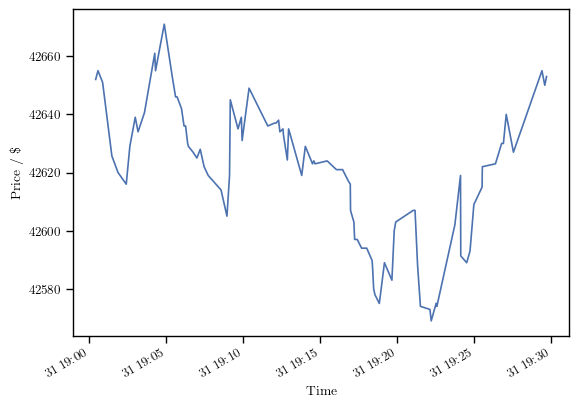

In [13]:
fig, ax = plt.subplots()
data["Price"][
    (datetime.datetime(2023, 12, 31, 19, 0) < data.index)
    & (data.index < datetime.datetime(2023, 12, 31, 19, 30))
].plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel(latexEscape("Price / $"))

1-month time span plot of BTC price.

Text(0, 0.5, 'Price / \\$')

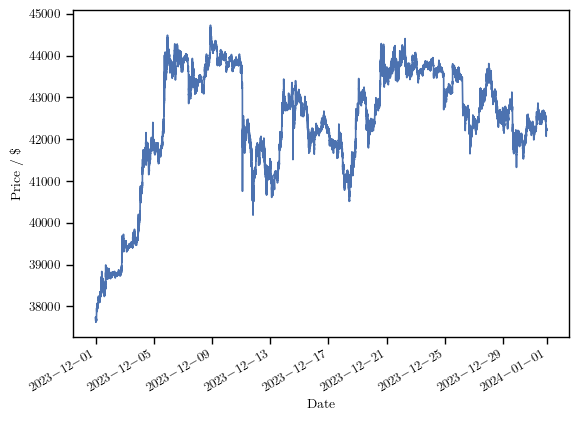

In [14]:
fig, ax = plt.subplots()
data["Price"][
    (datetime.datetime(2023, 12, 1, 0, 0) < data.index)
    & (data.index < datetime.datetime(2024, 1, 1, 0, 0))
].plot(ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel(latexEscape("Price / $"))

Forward fill price data to get a price each second.

Text(0, 0.5, 'Price / \\$')

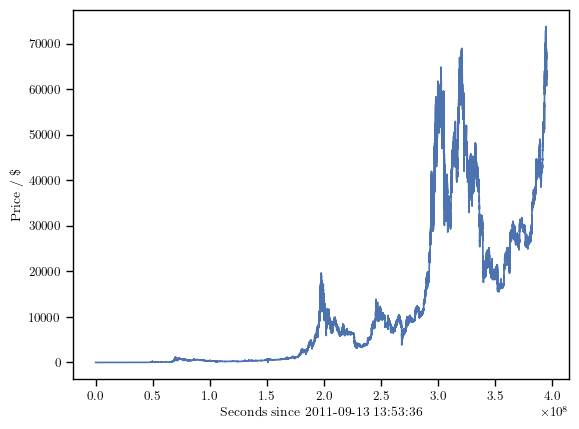

In [15]:
prices = data["Price"].copy()
prices.index = (data.index - data.index[0]) // pd.Timedelta("1s")
prices = prices.reindex(
    np.arange(prices.index[0], prices.index[-1]), fill_value=np.nan
).ffill()

fig, ax = plt.subplots()
prices.plot(ax=ax)
ax.set_xlabel(f"Seconds since {data.index[0]}")
ax.set_ylabel(latexEscape("Price / $"))

Find variance at different sampling frequencies.

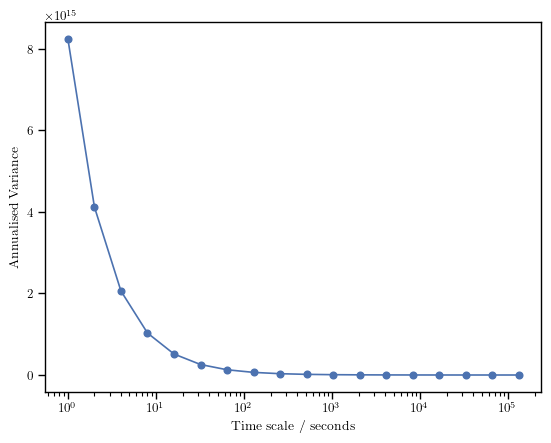

In [16]:
timescales = np.array([2**intervalpow for intervalpow in range(18)])
secondsInYear = 3600 * 24 * 365
annVariances = np.array(
    [prices[::ts].var() * secondsInYear / ts for ts in timescales]  # type: ignore
)

fig, ax = plt.subplots()
ax.set_xscale("log")
ax.plot(timescales, annVariances, "-o")
ax.set_xlabel("Time scale / seconds")
ax.set_ylabel("Annualised Variance")
fig.savefig(BASEDIR / r"M2 - BTC variance timescales.pdf", bbox_inches="tight")

Text(0, 0.5, 'Annualised Variance')

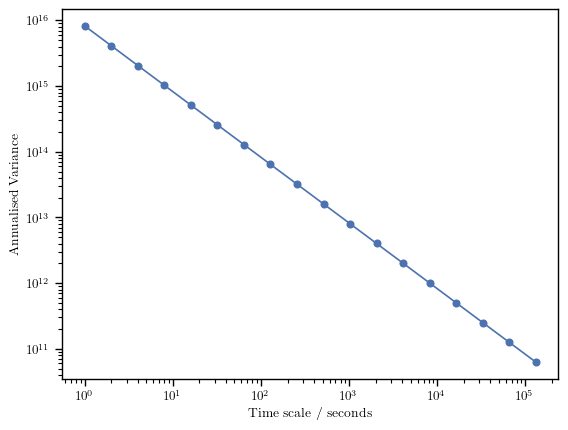

In [17]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(timescales, annVariances, "-o")
ax.set_xlabel("Time scale / seconds")
ax.set_ylabel("Annualised Variance")

In [18]:
import sklearn.linear_model

reg = sklearn.linear_model.LinearRegression().fit(
    np.log(timescales).reshape(-1, 1), np.log(annVariances)
)
print(reg.intercept_, reg.coef_)

36.647198459054444 [-0.99991479]


In [19]:
np.array([prices[::ts].std() for ts in timescales])

array([16162.13116802, 16162.13105775, 16162.13099036, 16162.13160245,
       16162.13085028, 16162.12976968, 16162.13865066, 16162.13503797,
       16162.13950509, 16162.14017632, 16162.27853395, 16162.19987311,
       16162.54618989, 16163.54005884, 16163.55562226, 16163.48785642,
       16171.41865232, 16178.23392817])

Different approach: take rolling windows of equal size (and therefore
different lengths of absolute time).

Text(0, 0.5, 'Annualised Standard Deviation')

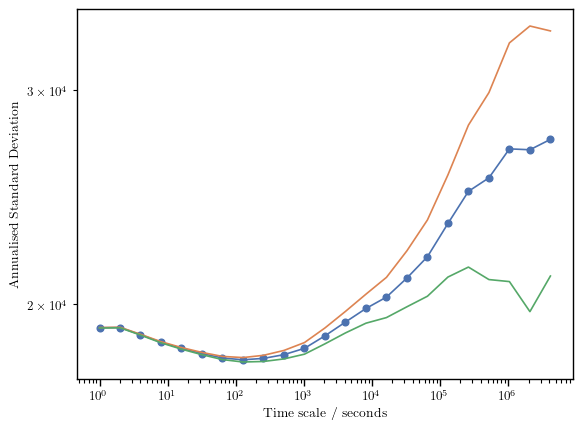

In [20]:
def rollingStdScales(
    xs: Iterable, /, *, window: int = 50
) -> tuple[np.ndarray, np.ndarray]:
    vmean, vstd = [], []
    arr = pd.Series(xs)  # type: ignore
    while len(arr) > window:
        vs = arr.rolling(window=window).std()
        vmean.append(vs.mean())
        vstd.append(vs.std())
        arr = arr[::2]
    return np.array(vmean), np.array(vstd)


stdM, stdStd = rollingStdScales(prices)
stdAnn = stdM * np.sqrt(secondsInYear / 2 ** np.arange(len(stdM)))

fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(2 ** np.arange(len(stdAnn)), stdAnn, "-o")
ax.plot(2 ** np.arange(len(stdAnn)), stdAnn + stdStd, "-")
ax.plot(2 ** np.arange(len(stdAnn)), stdAnn - stdStd, "-")
ax.set_xlabel("Time scale / seconds")
ax.set_ylabel("Annualised Standard Deviation")

Text(0, 0.5, 'SD of SD')

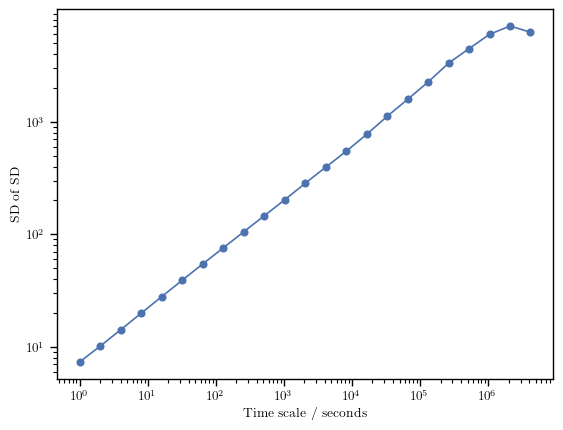

In [21]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.plot(2 ** np.arange(len(stdStd)), stdStd, "-o")
ax.set_xlabel("Time scale / seconds")
ax.set_ylabel("SD of SD")

## Theory

Visualisation of MACD filter Fourier coefficients. The array below was
computed in Mathematica.

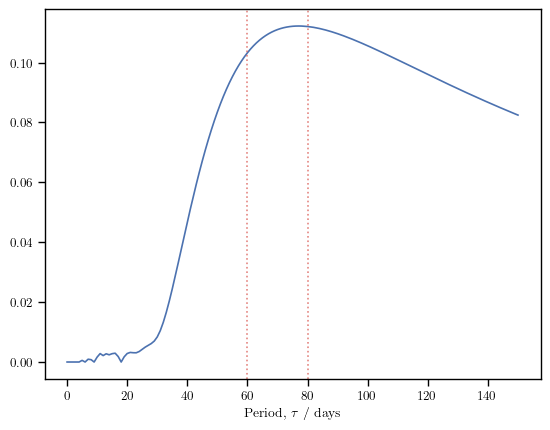

In [22]:
# fmt: off
macdFT = [
    0., 0., 0., 0., 0., 0.000546181, 0., 0.000936122, 0.000779668, 0., 0.00164285, 0.00280958, 0.00214851, 0.00274118, 0.0024081, 0.0027821, 0.00293688, 0.00183783, 0., 0.00173986, 0.00283944,
    0.00319732, 0.00309986, 0.0030794, 0.0035085, 0.00424001, 0.00496988, 0.00557641, 0.00616014, 0.00699306, 0.00837678, 0.0104667, 0.0132384, 0.0165777, 0.0203545, 0.0244503, 0.0287638, 0.0332096,
    0.0377167, 0.0422262, 0.0466901, 0.0510698, 0.0553345, 0.0594606, 0.0634302, 0.0672305, 0.0708527, 0.0742916, 0.0775447, 0.0806119, 0.0834949, 0.0861969, 0.0887222, 0.0910759, 0.0932639, 0.0952925,
    0.0971681, 0.0988975, 0.100488, 0.101945, 0.103277, 0.104489, 0.105588, 0.106581, 0.107473, 0.108271, 0.108978, 0.109602, 0.110147, 0.110618, 0.111019, 0.111355, 0.11163, 0.111847, 0.112011, 0.112124,
    0.112191, 0.112214, 0.112196, 0.11214, 0.112048, 0.111923, 0.111768, 0.111583, 0.111372, 0.111136, 0.110877, 0.110597, 0.110297, 0.109979, 0.109643, 0.109293, 0.108927, 0.108549, 0.108158, 0.107756,
    0.107344, 0.106922, 0.106492, 0.106055, 0.10561, 0.105159, 0.104702, 0.10424, 0.103774, 0.103304, 0.10283, 0.102353, 0.101874, 0.101392, 0.100909, 0.100424, 0.0999384, 0.0994517, 0.0989646, 0.0984772,
    0.0979899, 0.0975028, 0.0970162, 0.0965303, 0.0960453, 0.0955614, 0.0950787, 0.0945973, 0.0941175, 0.0936393, 0.093163, 0.0926885, 0.092216, 0.0917457, 0.0912775, 0.0908116, 0.090348, 0.0898869,
    0.0894283, 0.0889722, 0.0885187, 0.0880678, 0.0876196, 0.0871742, 0.0867315, 0.0862917, 0.0858546, 0.0854204, 0.0849891, 0.0845607, 0.0841351, 0.0837125, 0.0832928, 0.0828761, 0.0824622,
]
# fmt: on

fig, ax = plt.subplots()
ax.plot(macdFT)
ax.axvline(x=60, color="xkcd:pale red", alpha=0.7, linestyle="dotted")
ax.axvline(x=80, color="xkcd:pale red", alpha=0.7, linestyle="dotted")
ax.set_xlabel(r"Period, $\tau$ / days")
fig.savefig(
    BASEDIR / "M6 - MACD(24,52,18) fourier coefficients.pdf", bbox_inches="tight"
)
del macdFT

## NSI Equity

### Metadata management

Helper functions to normalise tickers (by stripping spaces and capitalising)
and parse date with time.

In [23]:
def normaliseTickers(tickers: pd.Series) -> pd.Series:
    import string

    return tickers.str.translate({ord(c): None for c in string.whitespace}).str.upper()


def cleanLabel(colname: str) -> str:
    return colname.strip().removeprefix("<").removesuffix(">")


def parseDateTime(
    df: pd.DataFrame,
    /,
    *,
    datecol: str,
    timecol: str,
    month: int,
    debugMsg: NoneType | str = None,
) -> pd.Series:
    import warnings

    def parseDate(dts, /, *, dayfirst: bool):
        try:
            parsedDates = pd.to_datetime(dts, dayfirst=dayfirst, yearfirst=False)
        except ValueError:
            parsedDates = None
        return parsedDates

    # some files (e.g. PEL) have mixed date separators
    dateStrsClean = df[datecol].str.replace("/", "-")
    with warnings.catch_warnings(action="ignore"):
        # some file (e.g. PEL again) have mixed time formats. This is a horrible
        # hack to put them into a standard form.
        #
        # Dev note: ideally, we would use pd.to_timedelta, but that parser does
        # not recognise the hh:mm format (that yet again appears in e.g. PEL).
        timeStrsClean = pd.to_datetime(df[timecol]).apply(
            lambda x: x.strftime(r"%H:%M:%S")
        )
        datetimeStrsClean = dateStrsClean + " " + timeStrsClean
        # suppress warnings when dayfirst argument is ignored
        dayFirstDT = parseDate(datetimeStrsClean, dayfirst=True)
        monthFirstDT = parseDate(datetimeStrsClean, dayfirst=False)
    if dayFirstDT is not None and (
        monthFirstDT is None
        or (
            set(dayFirstDT.dt.month) == {month}
            and set(monthFirstDT.dt.month) != {month}
        )
    ):
        parsedDT = dayFirstDT
    elif monthFirstDT is not None and (
        dayFirstDT is None
        or (
            set(monthFirstDT.dt.month) == {month}
            and set(dayFirstDT.dt.month) != {month}
        )
    ):
        parsedDT = monthFirstDT
    elif dayFirstDT is not None and np.all(dayFirstDT == monthFirstDT):
        # sometimes exception will not be raised, and parsing quietly falls back
        parsedDT = dayFirstDT
    else:
        raise ValueError(
            "Ambiguous month" + (f": {debugMsg}" if debugMsg is not None else "")
        )
    # set month because some datasets (e.g. 5PAISA) have the wrong month
    parsedDT = parsedDT.apply(lambda d: d.replace(month=month))
    parsedDT.name = "time"
    return parsedDT

Function to perform the heavy lifting of retrieving metadata from the RAR data
files, such as a full list of tickers, and start/end dates + number of data
points for each ticker.

In [24]:
async def fetchTickerInfo(
    *, basedir: Path = BASEDIR, startyear=2021, endyear=2023
) -> pd.DataFrame:
    import calendar
    from rarfile import RarFile

    def getStats(year: int, month: int) -> list[tuple[str, tuple]]:
        stats = []
        arxName = f"Cash Data {calendar.month_name[month]} {year}.rar"
        try:
            with RarFile(basedir / "data" / arxName, "r") as arx:
                dataPaths = [
                    path for path in map(Path, arx.namelist()) if path.suffix == ".csv"
                ]
                debugFileCount = 0
                for dataPath in dataPaths:
                    ticker = dataPath.stem
                    with arx.open(dataPath) as dataFile:
                        df = pd.read_csv(dataFile)
                    dates = parseDateTime(
                        df,
                        datecol="<date>",
                        timecol="<time>",
                        month=month,
                        debugMsg=f'in archive "{arxName}" file "{dataPath}" ',
                    )
                    startDate = min(dates)
                    endDate = max(dates)
                    count = len(df)
                    del df
                    stats.append((ticker, (startDate, endDate, count)))
                    debugFileCount += 1
                    if debugFileCount % 20 == 0:
                        print(".", end="")
        except FileNotFoundError:
            pass
        return stats

    def foldf(
        acc: dict[str, tuple], res: Iterable[tuple[str, tuple]]
    ) -> dict[str, tuple]:
        for ticker, (start, end, count) in res:
            if ticker in acc:
                s, e, c = acc[ticker]
                acc[ticker] = (
                    min(s, start),
                    max(e, end),
                    c + count,
                )
            else:
                acc[ticker] = (start, end, count)
        return acc

    tickerStats: dict[str, tuple] = await concurrent_map_fold(
        itertools.product(range(startyear, endyear + 1), range(1, 13)),
        lambda t: getStats(*t),
        foldf,
        acc={},
    )  # type: ignore
    tickers = list(tickerStats.keys())
    df = pd.DataFrame(
        {
            "start": [tickerStats[t][0] for t in tickers],
            "end": [tickerStats[t][1] for t in tickers],
            "count": [tickerStats[t][2] for t in tickers],
        },
        index=tickers,
    )
    df.index.name = "ticker"
    df.sort_index(inplace=True)
    return df

Aside from the metadata that can be obtain from the data files, we also want
to know the ticker type (e.g. equity / index / ETFs). To do this, we have to
resort to manually fetching data from the Indian stock exchange.

The `fetchTickerInfo` function is slow, as it has to dig through thousands of
tickers. The following function fetches transaction volume and last price for
a given month.

In [25]:
def fetchTradeVolumeAndPrice(
    year,
    month,
    /,
    *,
    basedir: Path = BASEDIR,
) -> pd.DataFrame:
    import calendar
    from rarfile import RarFile

    arxName = f"Cash Data {calendar.month_name[month]} {year}.rar"
    tickers = []
    volumePerDay = []
    lastPrice = []
    with RarFile(basedir / "data" / arxName, "r") as arx:
        dataPaths = [
            path for path in map(Path, arx.namelist()) if path.suffix == ".csv"
        ]
        for dataPath in dataPaths:
            ticker = dataPath.stem
            with arx.open(dataPath) as dataFile:
                df = pd.read_csv(dataFile)
            df.rename(columns=cleanLabel, inplace=True)
            df.index = parseDateTime(  # type: ignore
                df,
                datecol="date",
                timecol="time",
                month=month,
                debugMsg=f'in archive "{arxName}" file "{dataPath}" ',
            ).values
            tickers.append(ticker)
            volumePerDay.append(sum(df["volume"] * df["close"]) / len(df))
            lastPrice.append(df["close"].loc[max(df.index)])

    return pd.DataFrame(
        {
            f"{year}{month} $ volume per day": volumePerDay,
            f"{year}{month} last price": lastPrice,
        },
        index=tickers,
    )

We cache the results in `metadata.csv` for convenience. If you don't have this
file, you'll need to mark the cells above as "code" and run them.

In [26]:
with open(BASEDIR / "data" / "metadata.csv") as f:
    info = pd.read_csv(f, index_col="ticker", parse_dates=["start", "end"])
info["type"] = info["type"].fillna("").astype("string")
display(info)

,start,end,count,type,202312 $ volume per day,202312 last price
ticker,,,,,,
.CNX100,2021-01-04 09:07:00,2023-09-15 15:31:00,7171,,NaN,NaN
.CNXIT,2021-01-01 09:07:00,2023-09-15 15:31:00,29178,,NaN,NaN
.NSEBANK,2021-01-01 09:07:00,2023-09-15 15:31:00,29177,,NaN,NaN
.NSEI,2021-01-01 09:07:00,2023-09-15 15:31:00,29177,,NaN,NaN
20MICRONS,2021-01-01 09:15:00,2023-12-29 15:29:00,167616,equity,1.376759e+05,178.40
...,...,...,...,...,...,...
ZUARI,2021-01-01 09:15:00,2023-12-29 15:40:00,181233,equity,4.371536e+05,188.95
ZUARIGLOB,2021-01-01 09:15:00,2022-07-01 15:50:00,64958,,NaN,NaN
ZUARIIND,2022-07-04 09:15:00,2023-12-29 15:40:00,60289,equity,3.065890e+05,197.35


Look at stock daily trading volumes.

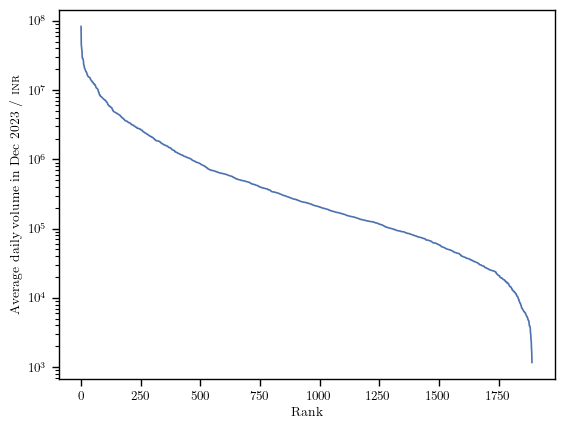

In [27]:
volumes = info[
    (info["type"] == "equity")
    & (np.logical_not(np.isnan(info["202312 $ volume per day"])))
]["202312 $ volume per day"].values
volumes[::-1].sort()

fig, ax = plt.subplots()
ax.plot(np.arange(len(volumes)), volumes)
ax.set_yscale("log")
ax.set_xlabel("Rank")
ax.set_ylabel("Average daily volume in Dec 2023 / " + latexTextSC("inr"))
fig.savefig(BASEDIR / r"M4 - 202312 equity daily volumes.pdf", bbox_inches="tight")

We only want equity stocks that have good liquidity.

In [28]:
equityUniverse = info[
    (info["type"] == "equity")
    & (info["202312 $ volume per day"] > 5e6)
    & (info["202312 last price"] >= 100)
].sort_values("202312 $ volume per day", ascending=False)
display(equityUniverse.shape)
with pd.option_context("display.max_rows", 500):
    display(equityUniverse)

(123, 6)

,start,end,count,type,202312 $ volume per day,202312 last price
ticker,,,,,,
HDFCBANK,2021-01-01 09:15:00,2023-12-29 15:40:00,278468,equity,8.289933e+07,1709.25
ICICIBANK,2021-01-01 09:15:00,2023-12-29 15:40:00,278413,equity,4.489767e+07,996.60
RELIANCE,2021-01-01 09:15:00,2023-12-29 15:40:00,278519,equity,4.236298e+07,2584.95
ADANIENT,2021-01-01 09:15:00,2023-12-29 15:40:00,278333,equity,3.862592e+07,2848.95
SBIN,2021-01-01 09:15:00,2023-12-29 15:40:00,278521,equity,2.963449e+07,642.05
ADANIPORTS,2021-01-01 09:15:00,2023-12-29 15:40:00,278434,equity,2.860442e+07,1024.35
IREDA,2023-11-29 09:55:00,2023-12-29 16:00:00,8255,equity,2.855586e+07,102.80
AXISBANK,2021-01-01 09:15:00,2023-12-29 15:40:00,278366,equity,2.835048e+07,1102.30
TATAPOWER,2021-01-01 09:15:00,2023-12-29 15:40:00,278612,equity,2.762074e+07,332.15


For now, we just look at stock which have been around since Jan 2021.

In [29]:
equityUniverse.drop(
    equityUniverse[equityUniverse["start"].dt.date > datetime.date(2021, 1, 1)].index,
    inplace=True,
)
display(equityUniverse)

,start,end,count,type,202312 $ volume per day,202312 last price
ticker,,,,,,
HDFCBANK,2021-01-01 09:15:00,2023-12-29 15:40:00,278468,equity,8.289933e+07,1709.25
ICICIBANK,2021-01-01 09:15:00,2023-12-29 15:40:00,278413,equity,4.489767e+07,996.60
RELIANCE,2021-01-01 09:15:00,2023-12-29 15:40:00,278519,equity,4.236298e+07,2584.95
ADANIENT,2021-01-01 09:15:00,2023-12-29 15:40:00,278333,equity,3.862592e+07,2848.95
SBIN,2021-01-01 09:15:00,2023-12-29 15:40:00,278521,equity,2.963449e+07,642.05
...,...,...,...,...,...,...
SBILIFE,2021-01-01 09:15:00,2023-12-29 15:40:00,278167,equity,5.383514e+06,1432.60
GMDCLTD,2021-01-01 09:15:00,2023-12-29 15:40:00,268876,equity,5.324147e+06,407.00
RCF,2021-01-01 09:15:00,2023-12-29 15:40:00,276914,equity,5.178524e+06,159.50


# Asset price analysis

This function does the heavy lifting of retrieving a time series from the data
files.

In [30]:
@functools.lru_cache(maxsize=32)
def fetchTicker(
    ticker: str,
    /,
    *,
    basedir: Path = BASEDIR,
    startyear=2021,
    endyear=2023,
) -> pd.DataFrame:
    import calendar
    from rarfile import RarFile

    data = []
    for year in range(startyear, endyear + 1):
        for month in range(1, 13):
            arxName = f"Cash Data {calendar.month_name[month]} {year}.rar"
            with RarFile(basedir / "data" / arxName, "r") as arx:
                indexArxPaths = [
                    path
                    for path in map(Path, arx.namelist())
                    if path.suffix == ".csv" and ticker == path.stem
                ]
                if len(indexArxPaths) > 1:
                    raise ValueError(
                        f"More than one file in archive {arxName} that matches ticker {ticker}"
                    )
                elif len(indexArxPaths) == 1:
                    with arx.open(indexArxPaths[0]) as f:
                        df = pd.read_csv(f)
                    df.rename(columns=cleanLabel, inplace=True)
                    df.index = parseDateTime(  # type: ignore
                        df,
                        datecol="date",
                        timecol="time",
                        month=month,
                        debugMsg=f"in archive {arxName}",
                    ).values
                    df.drop(
                        ["ticker", "date", "time"],
                        axis="columns",
                        inplace=True,
                        errors="ignore",
                    )
                    data.append(df)
    if not data:
        raise FileNotFoundError(f"Ticker {ticker} not found")
    df = pd.concat(data)
    allNullCols = df.isna().all(axis=0)
    df.drop(allNullCols[allNullCols].index, axis="columns", inplace=True)
    df.sort_index(inplace=True)
    df.index.name = "time"
    return df


def fetchTickersResampledAtTimes(
    tickers: Iterable[str],
    times: Iterable[str] | Iterable[datetime.time],
    /,
    *,
    colname="close",
) -> pd.DataFrame:
    def fillAsOf(sr: pd.Series, fullTickerData: dict[str, pd.Series]) -> pd.Series:
        naMask = sr.isna()
        sr.loc[naMask] = [
            fullTickerData[str(sr.name)].asof(t) for t in sr[naMask].index
        ]
        return sr

    fullTickerData = {}
    resampledList = []
    for ticker in tickers:
        srFull = fetchTicker(ticker)[colname]
        srFull.name = ticker
        fullTickerData[ticker] = srFull
        sr = timeseriesAtTimes(srFull, times)
        sr.name = ticker
        resampledList.append(sr)
    resampledData = pd.DataFrame().join(resampledList, how="outer")
    resampledData.index.name = "time"
    resampledData.apply(fillAsOf, args=(fullTickerData,), axis=0)
    return resampledData

Resample time series.

Resampling is slow, so we cache the results.

In [31]:
with open(BASEDIR / "data" / r"equity_universe_resampled_close.csv") as f:
    resampledData = pd.read_csv(f, index_col="time", parse_dates=True)
resampledData.columns = map(latexEscape, resampledData.columns)  # type: ignore
display(resampledData)

,HDFCBANK,ICICIBANK,RELIANCE,ADANIENT,SBIN,ADANIPORTS,AXISBANK,TATAPOWER,INFY,IRCTC,...,CIPLA,INDUSTOWER,BAJAJFINSV,AUROPHARMA,JINDALSTEL,SBILIFE,GMDCLTD,RCF,PEL,CDSL
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 10:00:00,1440.20,533.25,1987.30,489.45,277.95,487.40,621.20,76.10,1262.25,1444.55,...,822.50,233.65,8907.95,914.75,269.70,900.50,54.00,54.00,1445.80,533.75
2021-01-01 14:45:00,1433.60,528.85,1990.05,489.35,279.45,493.50,623.75,77.35,1262.30,1445.90,...,828.10,235.35,8901.00,929.00,271.65,897.00,54.85,54.20,1467.45,533.05
2021-01-04 10:00:00,1428.60,533.90,1978.60,497.20,283.10,505.85,631.60,78.85,1270.30,1457.40,...,829.50,240.00,9022.00,934.90,276.45,896.85,58.75,55.10,1480.35,533.70
2021-01-04 14:45:00,1414.00,529.35,1987.65,494.45,280.40,497.20,624.65,78.90,1286.70,1448.05,...,831.95,241.10,8874.80,960.55,284.60,902.00,58.30,54.35,1478.75,529.10
2021-01-05 10:00:00,1415.95,524.30,1969.75,496.50,278.20,501.80,637.70,78.50,1283.90,1438.70,...,832.30,245.80,8830.50,965.35,284.70,908.30,59.10,55.05,1444.80,526.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27 14:45:00,1699.00,998.45,2579.30,2844.15,646.45,1024.60,1099.75,325.00,1558.75,870.70,...,1239.85,184.75,1664.75,1069.50,733.80,1414.45,410.90,155.60,910.75,1844.00
2023-12-28 10:00:00,1715.20,1007.80,2595.90,2838.00,649.10,1024.40,1107.00,325.70,1563.00,866.65,...,1241.55,186.00,1688.20,1049.85,736.60,1441.00,409.65,154.00,920.55,1853.40
2023-12-28 14:45:00,1705.35,1001.25,2603.05,2824.50,650.40,1018.00,1108.35,327.35,1559.05,864.40,...,1258.05,185.60,1671.80,1075.00,734.55,1429.40,410.00,158.40,910.30,1834.85


/home/arthur/.cache/pypoetry/virtualenvs/nsi-mean-reversion-UVDFJrfB-py3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/arthur/.cache/pypoetry/virtualenvs/nsi-mean-reversion-UVDFJrfB-py3.11/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


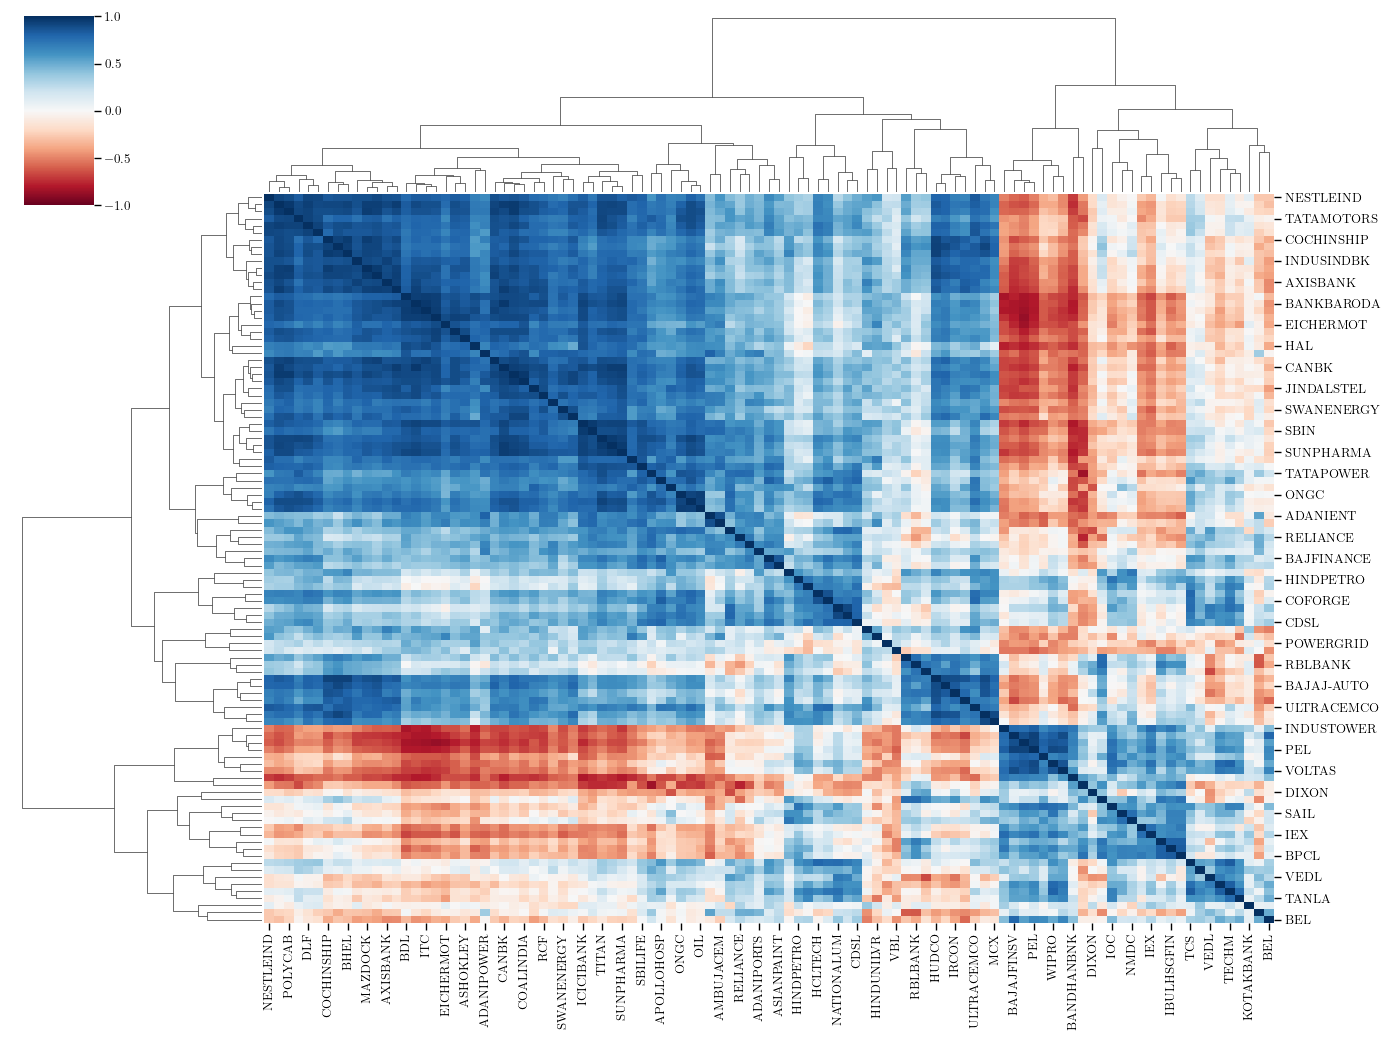

In [32]:
sns.clustermap(
    resampledData.corr(),
    method="complete",
    cmap="RdBu",
    annot=False,
    annot_kws={"size": 7},
    vmin=-1,
    vmax=1,
    figsize=(14, 10.5),
)

In [33]:
resampledData.corrwith(resampledData["HDFCBANK"]).sort_values(ascending=False).head(10)

HDFCBANK      1.000000
AXISBANK      0.683317
ULTRACEMCO    0.645719
INDUSINDBK    0.626601
BANKINDIA     0.595846
UNIONBANK     0.591605
BANKBARODA    0.576647
PIIND         0.562461
INDIGO        0.561772
ICICIBANK     0.554845
dtype: float64

As an example, let’s look at the ticker “5PAISA”.

In [34]:
ticker = "5PAISA"
data = fetchTicker(ticker)
display(data)

,open,high,low,close,volume,o/i
time,,,,,,
2021-01-01 09:15:00,307.90,307.90,307.90,307.90,5,0.0
2021-01-01 09:17:00,303.95,305.00,303.95,305.00,4,0.0
2021-01-01 09:18:00,305.00,305.00,305.00,305.00,155,0.0
2021-01-01 09:19:00,305.00,305.00,305.00,305.00,25,0.0
2021-01-01 09:20:00,305.00,305.00,305.00,305.00,3,0.0
...,...,...,...,...,...,...
2023-12-29 15:26:00,569.00,569.00,568.65,569.00,1025,NaN
2023-12-29 15:27:00,569.00,569.00,568.20,568.20,1312,NaN
2023-12-29 15:28:00,568.30,568.30,566.00,567.00,2356,NaN


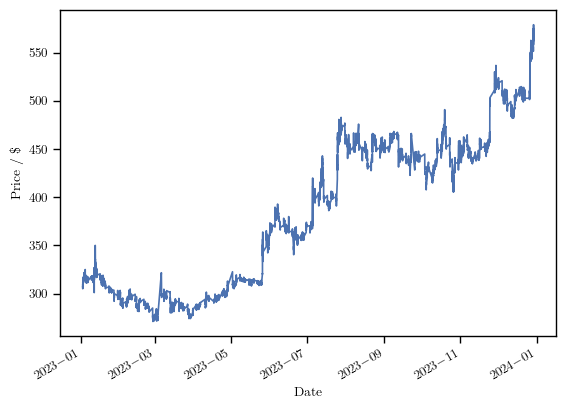

In [35]:
fig, ax = plt.subplots()
data["close"][
    (datetime.datetime(2023, 1, 1, 0, 0) <= data.index)
    & (data.index < datetime.datetime(2024, 1, 1, 0, 0))
].plot(ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel(latexEscape("Price / $"))
fig.savefig(BASEDIR / r"M3 - 5PAISA 2023.pdf", bbox_inches="tight")

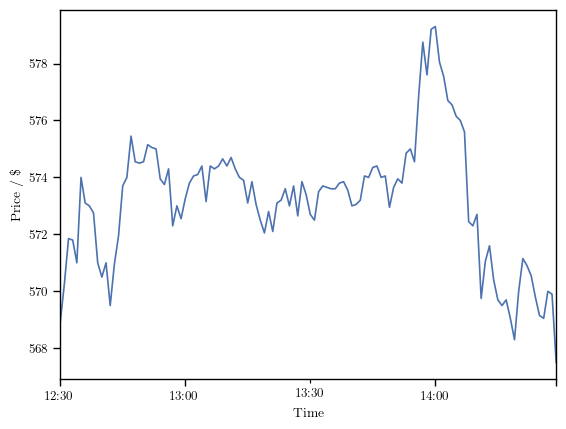

In [36]:
fig, ax = plt.subplots()
data["close"][
    (datetime.datetime(2023, 12, 29, 12, 30) <= data.index)
    & (data.index < datetime.datetime(2023, 12, 29, 14, 30))
].plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel(latexEscape("Price / $"))
fig.savefig(BASEDIR / r"M3 - 5PAISA 20231229 1230h.pdf", bbox_inches="tight")

IDEA on 3 Oct 2023. Note the quantised steps.

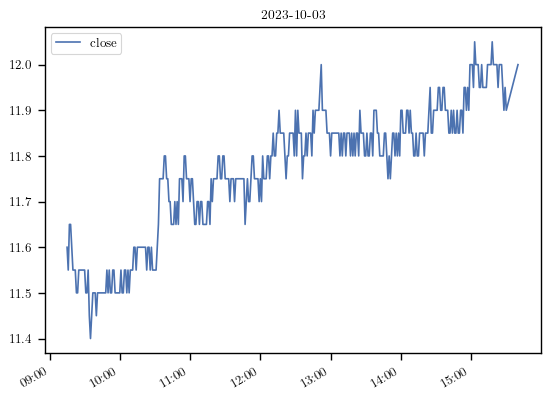

In [37]:
ticker = "IDEA"
data = fetchTicker(ticker)

fig = plotIntraday(
    data["close"],
    dates=[datetime.date(2023, 10, 3)],
    ncols=1,
    plotWidth=6.4,
    plotHeight=4.8,
)
fig.savefig(BASEDIR / r"M4 - IDEA 20231003.pdf", bbox_inches="tight")

GANGOTRI 2023 Q4 price. Note the illiquidity.

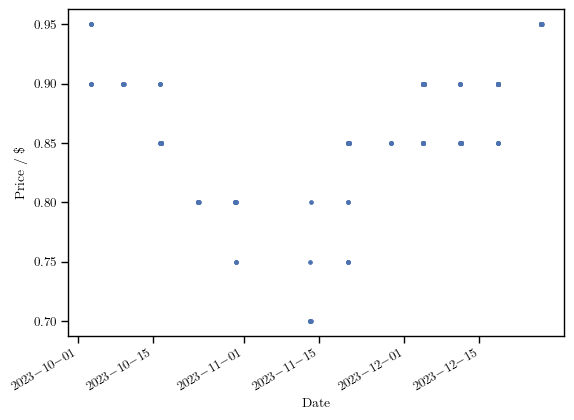

In [38]:
ticker = "GANGOTRI"
data = fetchTicker(ticker)

fig, ax = plt.subplots()
data["close"][
    (datetime.datetime(2023, 10, 1, 0, 0) <= data.index)
    & (data.index < datetime.datetime(2024, 1, 1, 0, 0))
].plot(ax=ax, style=".")
ax.set_xlabel("Date")
ax.set_ylabel(latexEscape("Price / $"))
fig.savefig(BASEDIR / r"M4 - GANGOTRI 2023Q4.pdf", bbox_inches="tight")

(278468, 6)


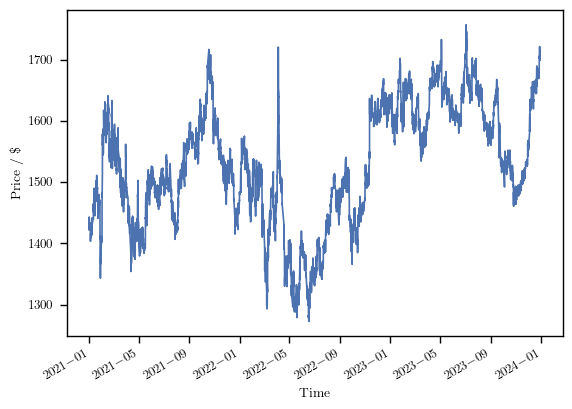

In [39]:
ticker = "HDFCBANK"
data = fetchTicker(ticker)

fig, ax = plt.subplots()
data["close"].plot(ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel(latexEscape("Price / $"))
print(data.shape)

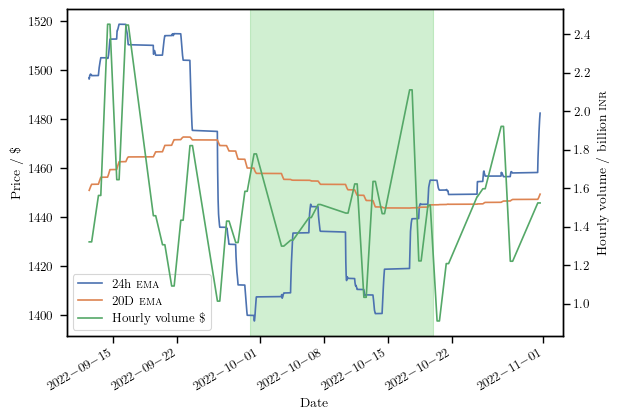

In [40]:
labelMap = {}
sr, srVol = data["close"], data["volume"]
ewm = pd.DataFrame()
for window in ["24h", "20D"]:
    label = f"{window} EMA"
    labelMap[label] = f"{latexEscape(window)} {latexTextSC('ema')}"
    ewm[label] = sr.ewm(
        halflife=pd.Timedelta(window),
        times=sr.index,  # type: ignore
    ).mean()
    del window, label
dollarVolSMA = (srVol * sr * 60 / 1e9).rolling(window="24h", center=True).mean()
dollarVolSMA.name = "Hourly volume $"
labelMap[dollarVolSMA.name] = latexEscape(dollarVolSMA.name)

applyLabelMap(labelMap, [ewm, dollarVolSMA])
fig = plotTimeseries(
    [ewm, dollarVolSMA],
    [[pd.Interval(pd.Timestamp(2022, 9, 30), pd.Timestamp(2022, 10, 20))]],
    plotInterval=pd.Interval(pd.Timestamp(2022, 9, 10), pd.Timestamp(2022, 11, 1)),
    ylabels=[latexEscape("Price / $"), f"Hourly volume / billion {latexTextSC('inr')}"],
    intervalColours=["xkcd:green"],
)
del labelMap, sr, srVol, ewm, dollarVolSMA
fig.savefig(BASEDIR / f"M6 - {ticker} mean reversion.pdf", bbox_inches="tight")

## Identify ideal trading intervals

### Identify largest returns historically

In [41]:
def findMaxReturnIntervals(
    prices: pd.Series, /, *, maxInterval: pd.Timedelta, queueSize=10, largest=True
) -> pd.DataFrame:
    def keepFirstN(d, queueSize: int) -> bool:
        hasDrop = False
        try:
            while True:
                d.popitem(index=queueSize)
                hasDrop = True
        except (IndexError, KeyError):
            pass
        return hasDrop

    returns = logReturn(prices, keepInitial=True)
    sortKeyF = (lambda x: (-x[0], x[1])) if largest else (lambda x: x)
    globalMaxSums = sortedcontainers.SortedDict(sortKeyF)
    maxSums = sortedcontainers.SortedDict(sortKeyF)
    hasDrop = False
    confidence = queueSize
    prevT, _ = next(rIt := iter(returns.items()))
    for t, val in rIt:
        for s, t0 in list(maxSums):
            del maxSums[(s, t0)]
            if t - t0 <= maxInterval:
                maxSums[(s + val, t0)] = t
        if hasDrop:
            confidence = min(confidence, len(maxSums))
        if t - prevT <= maxInterval:  # type: ignore
            maxSums[(val, prevT)] = t
        hasDrop = keepFirstN(maxSums, queueSize) or hasDrop
        globalMaxSums.update(maxSums.items())
        keepFirstN(globalMaxSums, queueSize)
        prevT = t
    df = pd.DataFrame.from_records(
        ((np.exp(s), t0, t1) for (s, t0), t1 in globalMaxSums.items()[:confidence]),
        columns=["return", "time start", "time end"],
    )
    df.index.name = "rank"
    return df


def findMaxReturnLongShortIntervals(
    prices: pd.Series, /, *, maxInterval: pd.Timedelta, queueSize=10
) -> pd.DataFrame:
    optimumLong = findMaxReturnIntervals(
        prices, maxInterval=maxInterval, queueSize=queueSize, largest=True
    )
    optimumLong["position"] = "long"
    optimumShort = findMaxReturnIntervals(
        prices, maxInterval=maxInterval, queueSize=queueSize, largest=False
    )
    optimumShort["return"] = 1 / optimumShort["return"]
    optimumShort["position"] = "short"
    optimum = (
        pd.concat([optimumLong, optimumShort])
        .sort_values(by="return", ascending=False)
        .head(n=min(len(optimumLong), len(optimumShort)))
        .reset_index(drop=True)
    )
    optimum.index.name = "rank"
    return optimum

### Identify ideal intervals based on MACD filtering

In [42]:
def findLargestIntervalsBefore0(
    sr: pd.Series,
    /,
    *,
    maxInterval: pd.Timedelta,
    threshold=0.5,  # number between 0 and 1. 0 means no filtering.
    thresholdInterval: pd.Timedelta | NoneType = None,
) -> pd.Series:
    if thresholdInterval is None:
        thresholdInterval = 10 * maxInterval

    srSign: pd.Series = np.sign(sr)  # type: ignore
    intervals = (
        srSign[srSign.diff().fillna(0) != 0]
        .to_frame(name="direction")
        .reset_index(names="time end")
    )
    intervals["time start not before"] = (
        intervals["time end"] + pd.Timedelta(seconds=1)
    ).shift(1, fill_value=intervals["time end"].min() - maxInterval)
    intervals["time start not before"] = np.maximum(
        intervals["time start not before"], intervals["time end"] - maxInterval
    )

    def getIdxExtrema(row):
        subseries = sr[
            (row["time start not before"] <= sr.index) & (sr.index < row["time end"])
        ]
        return (
            (pd.Series.idxmin if row["direction"] > 0 else pd.Series.idxmax)(subseries)
            if len(subseries) > 0
            else np.NaN
        )

    intervals["time start"] = intervals.apply(getIdxExtrema, axis=1)
    # drop intervals without data
    intervals.dropna(inplace=True)
    intervals["time interval"] = pd.arrays.IntervalArray.from_arrays(
        intervals["time start"], intervals["time end"], closed="left"
    )
    intervals = (
        intervals[["time interval", "direction"]]
        .set_index("time interval")
        .sort_index()
    )

    if threshold > 0:
        srAbs = sr.abs()
        intervals = intervals.drop(
            intervals[
                intervals.index.left.map(srAbs)  # type: ignore
                / intervals.apply(
                    lambda row: srAbs[
                        (row.name.right - thresholdInterval / 2 <= srAbs.index)
                        & (srAbs.index < row.name.right + thresholdInterval / 2)
                    ].max(),
                    axis=1,
                )
                < threshold
            ].index
        )

    intervals = intervals["direction"]
    intervals.name = "direction"
    return intervals


def findMACDOptimumReturnIntervals(
    price: pd.Series,
    /,
    *,
    macdParams: dict | NoneType = None,
    macdCenter: bool | tuple[bool, bool, bool] = (True, False, True),
    maxInterval: pd.Timedelta | NoneType = None,
    thresholdMACD=0.2,
    thresholdReturn=0.02,
):
    macdParams = macdParams or {"short": "24D", "long": "52D", "ave": "18D"}
    maxInterval = maxInterval or pd.Timedelta(days=24)
    macd = computeMACD(price, **macdParams, center=macdCenter)
    optimumTrades = findLargestIntervalsBefore0(
        macd, maxInterval=maxInterval, threshold=thresholdMACD
    ).to_frame()
    optimumTrades["duration"] = optimumTrades.index.length / pd.Timedelta(days=1)  # type: ignore
    optimumTrades["return"] = optimumTrades["direction"] * (
        optimumTrades.index.right.map(price) / optimumTrades.index.left.map(price) - 1  # type: ignore
    )
    optimumTrades = optimumTrades.drop(
        optimumTrades[optimumTrades["return"] <= thresholdReturn].index
    )
    return optimumTrades, macd

,direction,duration,return
time interval,,,
"[2021-02-15 09:15:00, 2021-03-10 10:40:00)",-1.0,23.059028,0.031131
"[2021-07-26 09:15:00, 2021-08-09 09:15:00)",1.0,14.000000,0.040017
"[2021-10-14 15:40:00, 2021-11-02 12:11:00)",-1.0,18.854861,0.041099
"[2022-01-14 15:40:00, 2022-01-31 09:15:00)",-1.0,16.732639,0.044721
"[2022-03-04 15:40:00, 2022-03-21 14:17:00)",1.0,16.942361,0.088547
"[2022-04-01 15:40:00, 2022-04-13 14:45:00)",-1.0,11.961806,0.023108
"[2022-10-03 09:15:00, 2022-10-24 18:15:00)",1.0,21.375000,0.030867
"[2023-10-27 15:40:00, 2023-11-17 14:29:00)",1.0,20.950694,0.024742


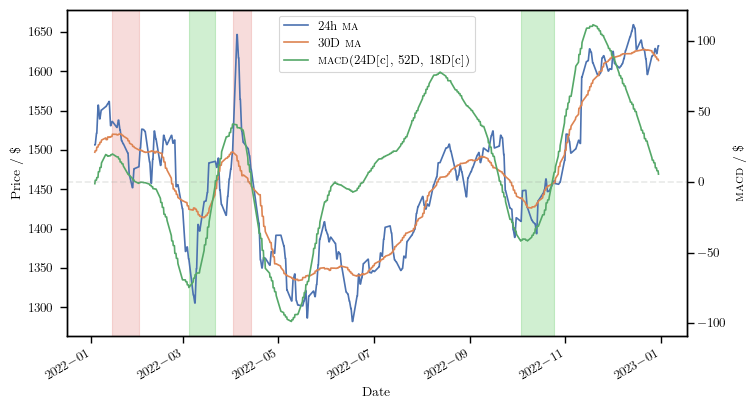

In [43]:
THRESHOLD = 0.5

sr = data["close"]
sma = pd.DataFrame()
for window in ["24h", "30D"]:
    sma[f"{latexEscape(window)} {latexTextSC('ma')}"] = sr.rolling(
        window=window, center=True
    ).mean()
    del window
optimumTrades, macdCen = findMACDOptimumReturnIntervals(sr)

display(optimumTrades)

start = pd.Timestamp(2022, 1, 1)
plotInterval = pd.Interval(start, start + pd.Timedelta(days=365))
macdCen.name = latexTextSC("macd") + latexEscape(
    macdCen.name.removeprefix(f"{sr.name} MACD")  # type: ignore
)
sr.name = latexTextSC(latexEscape(ticker.lower()))
fig = plotTimeseries(
    [sma, macdCen],
    [
        optimumTrades[optimumTrades["direction"] > THRESHOLD].index,
        optimumTrades[optimumTrades["direction"] < -THRESHOLD].index,
    ],  # type: ignore
    plotInterval=plotInterval,
    figsize=(8, 4.8),  # (14, 10.5)
    ylabels=[latexEscape("Price / $"), latexTextSC("macd") + latexEscape(" / $")],
    intervalColours=["xkcd:green", "xkcd:pale red"],
)
fig.axes[1].axhline(y=0, alpha=0.2, color="xkcd:grey", linestyle="--")
savePath = BASEDIR / f"M6 - {ticker} {plotInterval.left.year} trades"
fig.savefig(savePath.with_suffix(".pdf"), bbox_inches="tight")
fig.savefig(savePath.with_suffix(".png"), bbox_inches="tight")
del sr, sma, macdCen, optimumTrades, savePath

## Mean-reversion forecast model and cross-training

In [44]:
InferenceData = namedtuple("InferenceData", ["X", "y"])


def constructEquityFeatures(
    data: pd.DataFrame,
    /,
    *,
    tradingDays: pd.DatetimeIndex,
    priceCol="close",
    volumeCol="volume",
    dataLabel: str,
    prettyDataLabel: str | NoneType = None,
    prettyLabelMap: MutableMapping[str, str] | NoneType = None,
) -> pd.DataFrame:
    sr = data[priceCol]
    sr.name = dataLabel
    if prettyLabelMap is not None and dataLabel:
        if prettyDataLabel is None:
            prettyLabelMap[sr.name] = latexTextSC(latexEscape(dataLabel.lower()))
        else:
            prettyLabelMap[sr.name] = prettyDataLabel
    srPrefix = (sr.name + " ") if sr.name else ""
    if prettyLabelMap is not None:
        prettySrPrefix = (prettyLabelMap[sr.name] + " ") if sr.name else ""
    srDaily = timeseriesAsOfTimestamps(sr, tradingDays)
    ewm = computeMultiple(
        computeEWM,
        sr,
        minPeriods=10,
        multipleArgs=[{"window": w} for w in ["24h", "5D", "15D", "30D", "60D"]],
        prettyLabelMap=prettyLabelMap,
    )
    ewm[label := f"{srPrefix}EWM(15D)/EWM(5D)"] = (
        ewm[f"{srPrefix}EWM(15D)"] / ewm[f"{srPrefix}EWM(5D)"]
    )
    if prettyLabelMap is not None:
        prettyLabelMap[label] = (
            f"{prettySrPrefix}{latexTextSC('ewm')}(15D)/{latexTextSC('ewm')}(5D)"  # type: ignore
        )
    del label
    macd = computeMultiple(
        computeMACD,
        sr,
        multipleArgs=[{}, {"short": "24D", "long": "52D", "ave": "18D"}],
        prettyLabelMap=prettyLabelMap,
    )
    rsi = computeMultiple(
        computeRSI,
        srDaily,
        minPeriods=10,
        multipleArgs=[{"period": w} for w in [14, 5]],
        prettyLabelMap=prettyLabelMap,
    )
    rsi[label := f"{srPrefix}RSI(14D)/RSI(5D)"] = (
        rsi[f"{srPrefix}RSI(14D)"] / rsi[f"{srPrefix}RSI(5D)"]
    )
    if prettyLabelMap is not None:
        prettyLabelMap[label] = (
            f"{prettySrPrefix}{latexTextSC('rsi')}(14D)/{latexTextSC('rsi')}(5D)"  # type: ignore
        )
    del label
    bollinger, stdDev = computeBollingerBands(srDaily, prettyLabelMap=prettyLabelMap)
    # TODO: add volume and dollar volume features
    shifts = [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 18, 22, 26]
    shiftedDaily = srDaily.shift(shifts).rename(  # type: ignore
        columns=lambda col: srPrefix + f"shift{col.removeprefix(srDaily.name)}"
    )
    rescaledFeatures = (
        stdDev.to_frame()
        .join([ewm, macd, shiftedDaily], how="left", sort=True)  # type: ignore
        .div(srDaily, axis="index")
    )
    X = rescaledFeatures.join([rsi], how="left", sort=True)
    X["time interval"] = pd.arrays.IntervalArray.from_breaks(
        list(X.index) + [X.index[-1] + pd.offsets.BDay()], closed="right"
    )
    X = X.set_index("time interval").rename_axis(columns="features")
    return X


def relevantProfitCapturedPerTicker(
    y: pd.Series,  # y is unused when targetIntervalsDirection is passed
    yPred: pd.Series | np.ndarray,
    /,
    *,
    targetThreshold: float,
    targetIntervalsDirection: pd.Series | NoneType = None,
    prices: pd.Series,
) -> tuple[float, float]:
    """Profits in the target interval are counted, losses inside and profits
    outside the target period are zero-rated. Losses outside the target period
    are penalised.
    """
    if targetIntervalsDirection is None:
        raise NotImplementedError
    if not (
        isinstance(y.index, pd.IntervalIndex)
        and isinstance(y.index[0].left, pd.Timestamp)  # type: ignore
    ):
        raise ValueError("y must be indexed by time intervals")
    if isinstance(yPred, np.ndarray):
        yPred = pd.Series(data=yPred, index=y.index)
    if not (
        isinstance(yPred.index, pd.IntervalIndex)
        and isinstance(yPred.index[0].left, pd.Timestamp)  # type: ignore
    ):
        raise ValueError("yPred must be indexed by time intervals")
    if targetThreshold < 0:
        raise ValueError("Target threshold must be positive")
    if not isinstance(prices.index, pd.DatetimeIndex):
        raise ValueError("Prices must be a time series")
    if len(targetIntervalsDirection) > 0 and not (
        isinstance(targetIntervalsDirection.index, pd.IntervalIndex)
        and isinstance(targetIntervalsDirection.index[0].left, pd.Timestamp)  # type: ignore
    ):
        raise ValueError("Target intervals must be indexed by time intervals")
    prices = prices.sort_index()

    targetIntervalTotalReturn = 1.0
    for interval in intervalIntersection(y.index, targetIntervalsDirection.index):
        candidateTargets = targetIntervalsDirection[
            targetIntervalsDirection.index.contains(  # type: ignore
                interval.left + pd.Timedelta(nanoseconds=1)  # type: ignore
            )
        ]
        assert len(candidateTargets) == 1
        targetInterval, direction = next(candidateTargets.items())  # type: ignore
        assert interval.left in targetInterval or (
            targetInterval.open_left and interval.left == targetInterval.left
        )
        assert interval.right in targetInterval or (
            targetInterval.open_right and interval.right == targetInterval.right
        )
        del candidateTargets, targetInterval
        gain: float = direction * (
            prices.asof(interval.right) / prices.asof(interval.left) - 1  # type: ignore
        )
        targetIntervalTotalReturn *= max(0, gain) + 1
    targetIntervalTotalReturn -= 1

    predLongIntervals = coalesceIntervals(yPred[yPred > targetThreshold].index)
    predShortIntervals = coalesceIntervals(yPred[yPred < -targetThreshold].index)

    relevantGains = 1.0
    for interval in intervalIntersection(
        predLongIntervals,
        targetIntervalsDirection[targetIntervalsDirection > targetThreshold].index,
    ):
        gain = prices.asof(interval.right) / prices.asof(interval.left) - 1  # type: ignore
        relevantGains *= max(0, gain) + 1
    for interval in intervalIntersection(
        predShortIntervals,
        targetIntervalsDirection[targetIntervalsDirection < -targetThreshold].index,
    ):
        gain = 1 - prices.asof(interval.right) / prices.asof(interval.left)  # type: ignore
        relevantGains *= max(0, gain) + 1

    nonTargetLosses = 1.0
    for interval in intervalDifference(
        predLongIntervals,
        targetIntervalsDirection[targetIntervalsDirection > targetThreshold].index,
    ):
        loss = 1 - prices.asof(interval.right) / prices.asof(interval.left)  # type: ignore
        nonTargetLosses *= 1 - max(0, loss)  # type: ignore
    for interval in intervalDifference(
        predShortIntervals,
        targetIntervalsDirection[targetIntervalsDirection < -targetThreshold].index,
    ):
        loss = prices.asof(interval.right) / prices.asof(interval.left) - 1  # type: ignore
        nonTargetLosses *= 1 - max(0, loss)  # type: ignore
    return relevantGains * nonTargetLosses - 1, targetIntervalTotalReturn


def relevantProfitCaptured(
    y: pd.Series,
    yPred: pd.Series | np.ndarray,
    /,
    *,
    prices: pd.Series | Callable[[str], pd.Series],
    targetThreshold: float,
    targetIntervalsDirection: pd.Series | NoneType = None,
) -> float:
    if targetIntervalsDirection is None:
        raise NotImplementedError
    if not (
        isinstance(y.index, pd.MultiIndex)
        and y.index.dtypes.keys()[0] == "ticker"
        and isinstance(y.index[0][1], pd.Interval)
        and isinstance(y.index[0][1].left, pd.Timestamp)
    ):
        raise ValueError("y must be indexed by ticker and time intervals")
    if isinstance(yPred, np.ndarray):
        yPred = pd.Series(data=yPred, index=y.index)
    if not (
        isinstance(yPred.index, pd.MultiIndex)
        and yPred.index.dtypes.keys()[0] == "ticker"
        and isinstance(yPred.index[0][1], pd.Interval)
        and isinstance(yPred.index[0][1].left, pd.Timestamp)
    ):
        raise ValueError("yPred must be indexed by ticker and time intervals")
    if isinstance(prices, pd.Series) and not (
        isinstance(prices.index, pd.MultiIndex)
        and prices.index.dtypes.keys()[0] == "ticker"
        and isinstance(prices.index[0][1], pd.Timestamp)
    ):
        raise ValueError("Prices must be indexed by ticker and datetime")
    if len(targetIntervalsDirection) > 0 and not (
        isinstance(targetIntervalsDirection.index, pd.MultiIndex)
        and targetIntervalsDirection.index.dtypes.keys()[0] == "ticker"
        and isinstance(targetIntervalsDirection.index[0][1], pd.Interval)
        and isinstance(targetIntervalsDirection.index[0][1].left, pd.Timestamp)
    ):
        raise ValueError(
            "Target intervals must be indexed by ticker and time intervals"
        )
    y, yPred = y.sort_index(), yPred.sort_index()

    performance = []
    for ticker in set(y.index.get_level_values("ticker")):
        ts = (
            prices(ticker)
            if isinstance(prices, Callable)
            else prices.loc(axis=0)[ticker]
        )
        perf, maxProfit = relevantProfitCapturedPerTicker(
            y.loc(axis=0)[ticker],
            yPred.loc(axis=0)[ticker],
            targetThreshold=targetThreshold,
            targetIntervalsDirection=targetIntervalsDirection.loc(axis=0)[ticker],
            prices=ts,
        )
        performance.append((1 + perf) / (1 + maxProfit))
    return np.mean(performance).astype(float)


def buildDataset(
    tickers: Iterable[str],
    /,
    *,
    tradingDays: pd.DatetimeIndex,
    testtime=None,
):
    testtime = testtime or pd.Timestamp(2023, 1, 1)
    prettyLabelMap = {}
    Xs, ys = {}, {}
    targetTrades = {}
    for ticker in tickers:
        data = fetchTicker(ticker)
        X = constructEquityFeatures(
            data,
            tradingDays=tradingDays,
            dataLabel="",
            prettyLabelMap=prettyLabelMap,
        ).dropna()
        Xs[ticker] = X
        targets, _ = findMACDOptimumReturnIntervals(data["close"])
        targetTrades[ticker] = targets

        def getDirection(t) -> int:
            for interval, direction in targets["direction"].items():
                if t in interval:
                    return direction
            return 0

        ys[ticker] = pd.Series(
            data=X.index.map(getDirection),
            index=X.index,
        ).rename("direction")
        del getDirection, targets, X
        del _
    Xs = pd.concat(Xs, names=["ticker"]).sort_index()
    ys = pd.concat(ys, names=["ticker"]).sort_index().rename("target direction")  # type: ignore
    targetTrades = pd.concat(targetTrades, names=["ticker"]).sort_index()
    testTimeCV = sklearn.model_selection.PredefinedSplit(
        np.where(ys.index.get_level_values("time interval").left >= testtime, 1, -1)
    )
    infData = InferenceData(Xs, ys)
    return infData, prettyLabelMap, testTimeCV, targetTrades

Scale features and fit SVM, using GridSearchCV to choose hyparameters.

In [45]:
def basicRegressionTreeModel(
    nfeatures: int,
    /,
    *,
    metrics: Sequence[tuple[str, str | Callable]],
    params: Mapping | NoneType = None,
    refit: str | int = 0,
    niter: int = 10,
    njobs: int = NJOBS,
    random_state=RANDSEED,
):
    from sklearn.preprocessing import RobustScaler
    from sklearn.ensemble import GradientBoostingRegressor

    baseEstimator = GradientBoostingRegressor(
        n_iter_no_change=10,
        tol=1e-7,
        random_state=random_state,
    )
    treeModel = sklearn.pipeline.Pipeline([  # fmt: skip
        ("TickerScaler", GroupedLevelTransformer(RobustScaler(unit_variance=True), level="ticker", keepColNames=True)),  # fmt: skip
        ("estimator", baseEstimator),
    ])  # fmt: skip
    if params is None:
        baseParamSpace = {
            "learning_rate": scipy.stats.loguniform(a=1e-4, b=1),
            "subsample": scipy.stats.uniform(loc=0.2, scale=0.8),
            "max_leaf_nodes": [None, 31],
            "max_depth": scipy.stats.logser(p=0.99),  # [None, 3],
            "min_samples_leaf": [5, 20],
            "max_features": [1 / np.sqrt(nfeatures), 0.3, 1.0],
        }
        paramSpace = {"estimator__" + k: v for k, v in baseParamSpace.items()}
        est = sklearn.model_selection.RandomizedSearchCV(
            treeModel,
            paramSpace,
            n_iter=niter,
            scoring={
                name: sklearn.metrics.make_scorer(score_func=f)
                if isinstance(f, Callable)
                else f
                for name, f in metrics
            },
            refit=metrics[refit][0] if isinstance(refit, int) else refit,  # type: ignore
            cv=sklearn.model_selection.TimeSeriesSplit(),
            n_jobs=njobs,
            verbose=0,
            random_state=random_state,
            error_score="raise",  # type: ignore
        )
    else:
        est = treeModel.set_params(**params)
    return est


def treeHDProjectionRegressionModel(
    treeEstimator,
    /,
    *,
    metrics: Sequence[tuple[str, str | Callable]],
    params: Mapping | NoneType = None,
    refit: str | int = 0,
    niter: int = 10,
    njobs: int = NJOBS,
    random_state=RANDSEED,
):
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.svm import LinearSVR

    baseEstimator = LinearSVR(max_iter=10**3, random_state=random_state)
    model = sklearn.pipeline.Pipeline([  # fmt: skip
        ("TreeTransformer", MethodCallTransformer(estimator=treeEstimator, prefit=True, suppressTransformWarnings=True)),  # fmt: skip
        ("OneHotEncoder", OneHotEncoder(handle_unknown="ignore")),
        ("estimator", baseEstimator),
    ])  # fmt: skip
    if params is None:
        baseParamSpace = {
            "epsilon": scipy.stats.loguniform(a=1e-20, b=1),
            "C": scipy.stats.loguniform(a=1e-5, b=1e3),
        }
        paramSpace = {"estimator__" + k: v for k, v in baseParamSpace.items()}
        est = sklearn.model_selection.RandomizedSearchCV(
            model,
            paramSpace,
            n_iter=niter,
            scoring={
                name: sklearn.metrics.make_scorer(score_func=f)
                if isinstance(f, Callable)
                else f
                for name, f in metrics
            },
            refit=metrics[refit][0] if isinstance(refit, int) else refit,  # type: ignore
            cv=sklearn.model_selection.TimeSeriesSplit(),
            n_jobs=njobs,
            verbose=0,
            random_state=random_state,
            error_score="raise",  # type: ignore
        )
    else:
        est = model.set_params(**params)
    return est

Construct train/test dataset.

In [46]:
%%time
tickers = ["HDFCBANK", "AXISBANK", "ULTRACEMCO", "INDUSINDBK", "BANKINDIA", "UNIONBANK", "BANKBARODA", "PIIND", "INDIGO", "ICICIBANK"]  # fmt: skip
tradingDays: pd.DatetimeIndex = resampledData.at_time(datetime.time(10, 0)).index  # type: ignore

infData, prettyLabelMap, testTimeCV, targetTrades = buildDataset(
    tickers, tradingDays=tradingDays
)

CPU times: user 56.5 s, sys: 1.13 s, total: 57.7 s
Wall time: 1min 5s


In [47]:
%%time
trainIdxs, _ = next(testTimeCV.split())
# sorting need for TimeSeriesSplit to work due to bad sklearn implementation
X = infData.X.iloc[trainIdxs].sort_index(level="time interval", axis=0)
y = infData.y.iloc[trainIdxs].sort_index(level="time interval", axis=0)
del trainIdxs
investedCount = sum(y != 0)
totalCount = len(y)
balanceInvested = {0: totalCount / 3 / (totalCount - investedCount)}
balanceInvested[1] = totalCount / 3 / (investedCount / 2)
balanceInvested[-1] = balanceInvested[1]
del investedCount, totalCount

prices: pd.Series = pd.concat(  # type: ignore
    {tic: fetchTicker(tic)["close"] for tic in set(y.index.get_level_values("ticker"))},
    names=["ticker"],
).sort_index()
metrics = [
    (
        "Relevant Profit Captured",
        functools.update_wrapper(  # sklearn requires the __name__ attribute
            functools.partial(
                relevantProfitCaptured,
                targetThreshold=THRESHOLD,
                targetIntervalsDirection=targetTrades["direction"],
                prices=prices,
            ),
            relevantProfitCaptured,
        ),
    ),
    ("Negative Mean Squared Error", "neg_mean_squared_error"),
    ("Coefficient of Determination", "r2"),
]
del prices

treeEst = basicRegressionTreeModel(
    len(infData.X.columns),
    metrics=metrics,
    niter=50,
    refit="Negative Mean Squared Error",
)
treeEst.fit(X, y, estimator__sample_weight=y.map(balanceInvested))

CPU times: user 6.13 s, sys: 3.17 s, total: 9.29 s
Wall time: 49.2 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise',
                   estimator=Pipeline(steps=[('TickerScaler',
                                              GroupedLevelTransformer(keepColNames=True,
                                                                      level='ticker',
                                                                      transformer=RobustScaler(unit_variance=True))),
                                             ('estimator',
                                              GradientBoostingRegressor(n_iter_no_change=10,
                                                                        tol=1e-07))]),
                   n_iter=50, n_jobs=6,
                   p...
                                        'estimator__min_samples_leaf': [5, 20],
                                        'estimator__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fdf92208ed0>},
                   refit='Negative Mean Squared Error',
                   scoring={'Coefficient of Determination': 'r2',
                            'Negative Mean Squared Error': 'neg_mean_squared_error',
                            'Relevant Profit Captured': make_scorer(relevantProfitCaptured, response_method='predict')})

In [48]:
%%time
est = treeHDProjectionRegressionModel(
    treeEst.best_estimator_,  # type: ignore
    metrics=metrics,
    niter=25,
    refit=0,  # type: ignore
)
est.fit(X, y)
del X, y
# del balanceInvested

/home/arthur/.cache/pypoetry/virtualenvs/nsi-mean-reversion-UVDFJrfB-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/arthur/.cache/pypoetry/virtualenvs/nsi-mean-reversion-UVDFJrfB-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/arthur/.cache/pypoetry/virtualenvs/nsi-mean-reversion-UVDFJrfB-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/arthur/.cache/pypoetry/virtualenvs/nsi-mean-reversion-UVDFJrfB-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/arthur/.cache/pypoetry/virtualenvs/nsi-mean-reversion-UVDF

CPU times: user 2.74 s, sys: 637 ms, total: 3.38 s
Wall time: 12.4 s


{'estimator__learning_rate': 0.00534915660798529,
 'estimator__max_depth': 463,
 'estimator__max_features': 0.19611613513818404,
 'estimator__max_leaf_nodes': None,
 'estimator__min_samples_leaf': 20,
 'estimator__subsample': 0.3383193068493914}

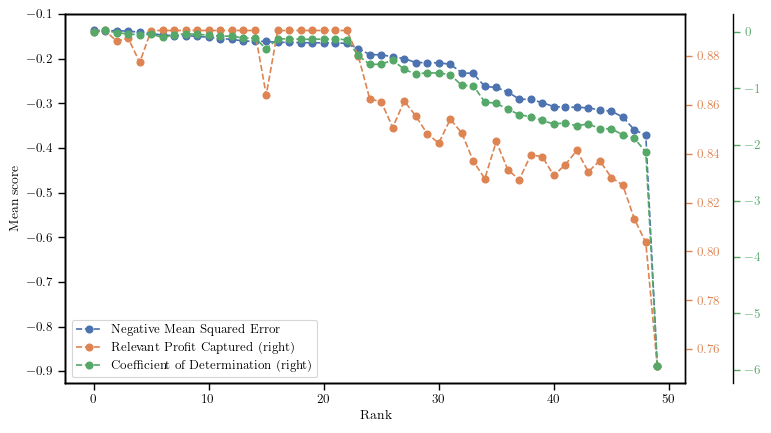

In [49]:
fig = plotCVMetrics(treeEst, figsize=(8, 4.8), showindex=False, showrank=False)
fig.savefig(
    BASEDIR / f"M7 - {tickers[0]} tree model - CV metrics.pdf", bbox_inches="tight"
)
display(treeEst.best_params_)  # type: ignore

{'estimator__C': 0.5903148008958142, 'estimator__epsilon': 0.1999104431643632}

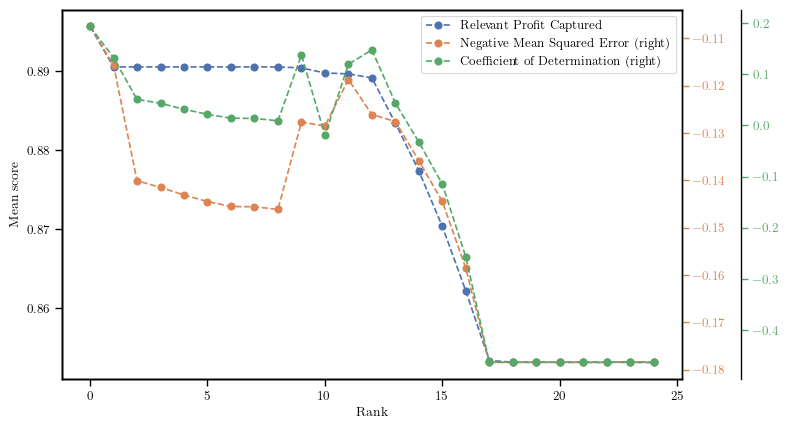

In [50]:
fig = plotCVMetrics(est, figsize=(8, 4.8), showindex=False, showrank=False)
fig.savefig(
    BASEDIR / f"M7 - {tickers[0]} SVM model - CV metrics.pdf", bbox_inches="tight"
)
display(est.best_params_)  # type: ignore

In [51]:
%%time
models = []
trainIdxs, _ = next(testTimeCV.split())
for tss in (tickers[:i] for i in range(1, len(tickers) + 1)):
    X = (
        infData.X.iloc[trainIdxs]
        .loc(axis=0)[tss, :]
        .sort_index(level="time interval", axis=0)
    )
    y = (
        infData.y.iloc[trainIdxs]
        .loc(axis=0)[tss, :]
        .sort_index(level="time interval", axis=0)
    )

    treeEst2 = basicRegressionTreeModel(
        len(infData.X.columns),
        metrics=metrics,
    )
    treeEst2.fit(X, y, estimator__sample_weight=y.map(balanceInvested))
    est2 = treeHDProjectionRegressionModel(
        treeEst2.best_estimator_,
        metrics=metrics,
    )
    est2.fit(X, y)
    models.append(est2)
    del tss, X, y, treeEst2, est2
del trainIdxs

/home/arthur/.cache/pypoetry/virtualenvs/nsi-mean-reversion-UVDFJrfB-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/arthur/.cache/pypoetry/virtualenvs/nsi-mean-reversion-UVDFJrfB-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/arthur/.cache/pypoetry/virtualenvs/nsi-mean-reversion-UVDFJrfB-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/arthur/.cache/pypoetry/virtualenvs/nsi-mean-reversion-UVDFJrfB-py3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/arthur/.cache/pypoetry/virtualenvs/nsi-mean-reversion-UVDF

CPU times: user 25.1 s, sys: 5.57 s, total: 30.7 s
Wall time: 1min 52s


In [52]:
%%time
def permutationTestScore(
    y, yPred, /, *, scoring: str | Callable[..., float], nPermutations=200
) -> tuple[float, np.ndarray, float]:
    def getScoreFunc(name: str) -> Callable[..., float]:
        scorer = sklearn.metrics.get_scorer(name)
        return lambda z, zPred: scorer._sign * scorer._score_func(z, zPred)

    scoreFunc: Callable[..., float] = (
        getScoreFunc(scoring) if isinstance(scoring, str) else scoring
    )
    permScores = np.array(
        [
            scoreFunc(
                y, y.sample(frac=1, replace=False, ignore_index=True).set_axis(y.index)
            )
            for _ in range(nPermutations)
        ]
    )
    score = scoreFunc(y, yPred)
    pvalue: float = (np.sum(permScores >= score) + 1.0) / (nPermutations + 1)  # type: ignore
    return score, permScores, pvalue


results = []
for est in models:
    scores = []
    for phase, idxs in zip(["train", "test"], next(testTimeCV.split()), strict=True):
        X = infData.X.iloc[idxs].loc(axis=0)[tickers[0], :]
        y = infData.y.iloc[idxs].loc(axis=0)[tickers[0], :]
        yPred = mapNumpyDataFrameToSeries(est.predict, X)
        for metric, scoring in metrics:
            score, _, pvalue = permutationTestScore(y, yPred, scoring=scoring)
            scores.append((phase, metric, score, pvalue))
            del metric, scoring, score, pvalue, _
        del phase, idxs, X, y, yPred
    results.append(
        pd.DataFrame.from_records(
            data=scores,
            columns=["phase", "metric", "score", "p-value"],
            index=["phase", "metric"],
        )
    )
    del est, scores
results = pd.concat({i + 1: r for i, r in enumerate(results)}, names=["ticker count"])
results.columns.name = "type"
display(results.unstack(level="metric"))

type                                      score                              \
metric             Coefficient of Determination Negative Mean Squared Error   
ticker count phase                                                            
1            test                     -1.953578                   -0.148405   
             train                     0.873955                   -0.019847   
2            test                     -0.979877                   -0.099480   
             train                     0.640845                   -0.056553   
3            test                     -1.456679                   -0.123438   
             train                     0.994102                   -0.000929   
4            test                     -0.085339                   -0.054534   
             train                     0.114057                   -0.139503   
5            test                     -0.064200                   -0.053471   
             train                     0.074235                   -0.145773   
6            test                     -0.255929                   -0.063105   
             train                     0.489728                   -0.080349   
7            test                     -0.327494                   -0.066701   
             train                     0.917898                   -0.012928   
8            test                     -0.166011                   -0.058587   
             train                     0.400869                   -0.094340   
9            test                     -0.056004                   -0.053060   
             train                    -0.004120                   -0.158111   
10           test                     -0.751171                   -0.087989   
             train                     0.864825                   -0.021285   

type                                                             p-value  \
metric             Relevant Profit Captured Coefficient of Determination   
ticker count phase                                                         
1            test                  0.946479                     1.000000   
             train                 0.710432                     0.004975   
2            test                  0.927353                     0.512438   
             train                 0.579192                     0.004975   
3            test                  0.891852                     1.000000   
             train                 0.729340                     0.004975   
4            test                  0.949971                     0.004975   
             train                 0.502280                     0.004975   
5            test                  0.949971                     0.004975   
             train                 0.502280                     0.004975   
6            test                  0.949971                     0.004975   
             train                 0.545109                     0.004975   
7            test                  0.949971                     0.004975   
             train                 0.731761                     0.004975   
8            test                  0.949971                     0.004975   
             train                 0.502840                     0.004975   
9            test                  0.949971                     0.004975   
             train                 0.502280                     0.004975   
10           test                  0.946074                     0.014925   
             train                 0.737794                     0.004975   

type                                                                     
metric             Negative Mean Squared Error Relevant Profit Captured  
ticker count phase                                                       
1            test                     1.000000                 0.024876  
             train                    0.004975                 0.004975  
2            test                     0.517413                 

CPU times: user 44.6 s, sys: 670 ms, total: 45.3 s
Wall time: 46.1 s


metric            Relevant Profit Captured            \
type                                 score   p-value   
Ticker Count, $n$                                      
1                                 0.946479  0.024876   
2                                 0.927353  0.248756   
3                                 0.891852  0.825871   
4                                 0.949971  0.019900   
5                                 0.949971  0.014925   
6                                 0.949971  0.009950   
7                                 0.949971  0.024876   
8                                 0.949971  0.024876   
9                                 0.949971  0.014925   
10                                0.946074  0.014925   

metric            Negative Mean Squared Error            \
type                                    score   p-value   
Ticker Count, $n$                                         
1                                   -0.148405  1.000000   
2                                   -0.099480  0.517413   
3                                   -0.123438  1.000000   
4                                   -0.054534  0.004975   
5                                   -0.053471  0.004975   
6                                   -0.063105  0.004975   
7                                   -0.066701  0.004975   
8                                   -0.058587  0.004975   
9                                   -0.053060  0.004975   
10                                  -0.087989  0.034826   

metric            Coefficient of Determination            
type                                     score   p-value  
Ticker Count, $n$                                         
1                                    -1.953578  1.000000  
2                                    -0.979877  0.512438  
3                                    -1.456679  1.000000  
4                                    -0.085339  0.004975  
5                                    -0.064200  0.004975  
6                                    -0.255929  0.004975  
7                                    -0.327494  0.004975  
8                                    -0.166011  0.004975  
9                                    -0.056004  0.004975  
10                                   -0.751171  0.014925

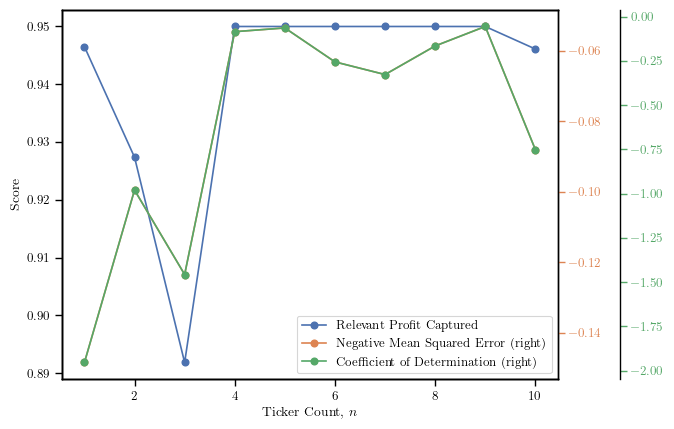

In [53]:
df = (
    results.loc(axis=0)[:, "test"]
    .droplevel("phase")
    .unstack(level="metric")
    .swaplevel(axis=1)
    .sort_index(axis=1, ascending=False)
)
df.index.name = "Ticker Count, $n$"
display(df)
fig = plotDataframeWSeperateYAxes(
    df.loc(axis=1)[:, "score"].droplevel("type", axis=1), figsize=(6.4, 4.8), marker="o"
)
fig.axes[0].set_ylabel("Score")
fig.savefig(BASEDIR / f"M7 - {tickers[0]} cross training perf.pdf", bbox_inches="tight")
del df, fig

Visual display of how well the model is fitting.

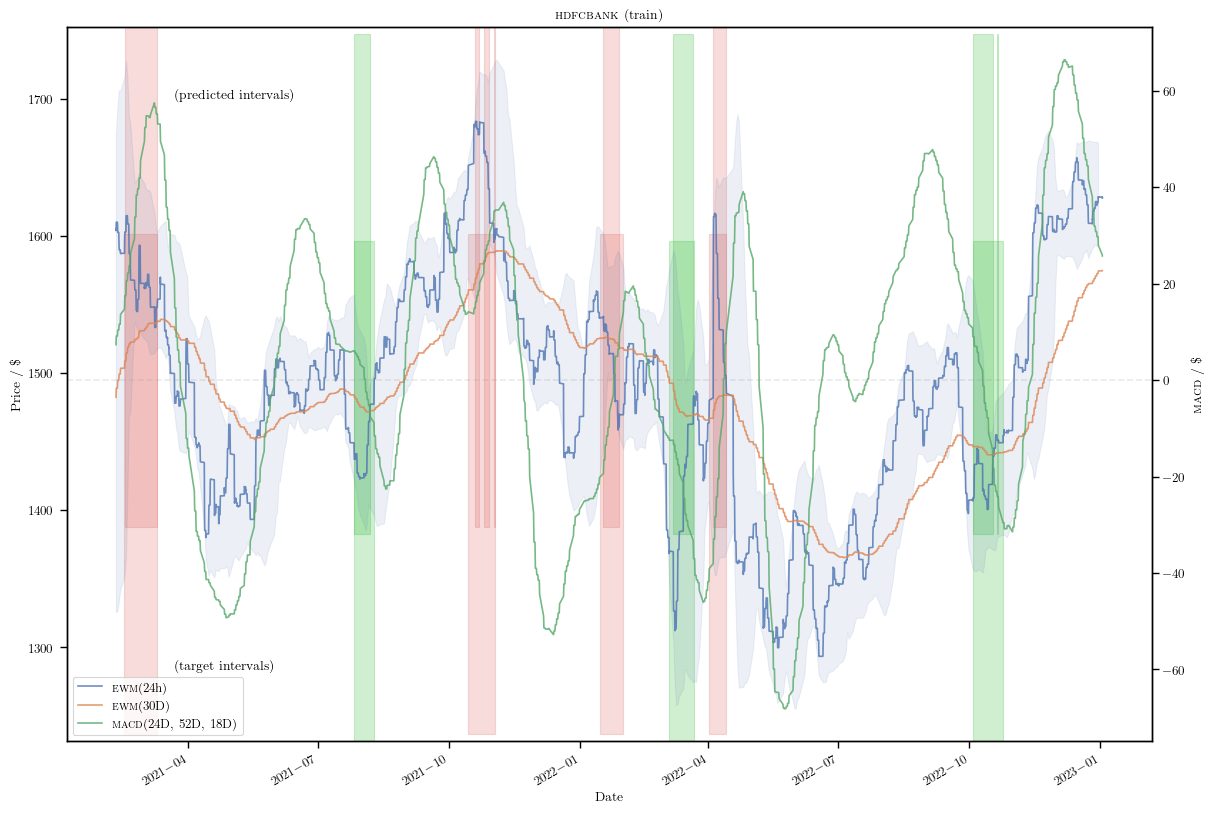

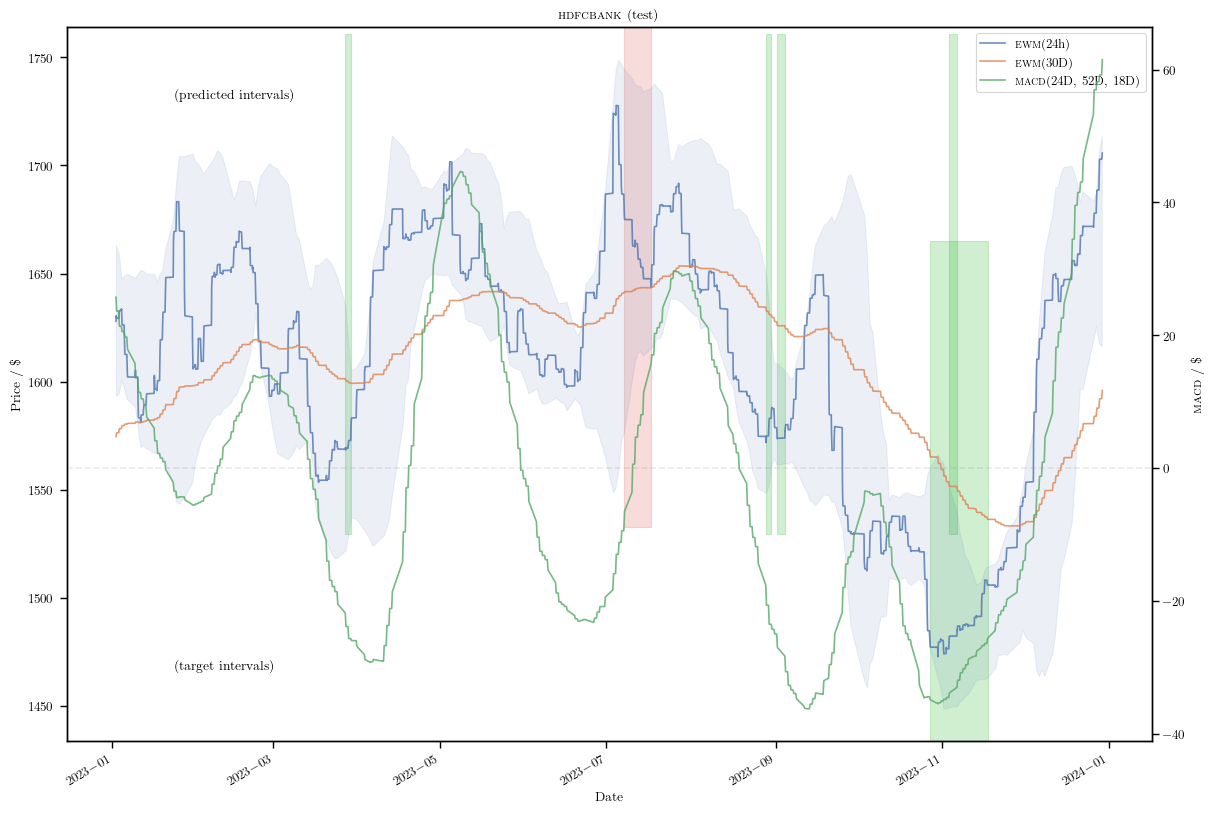

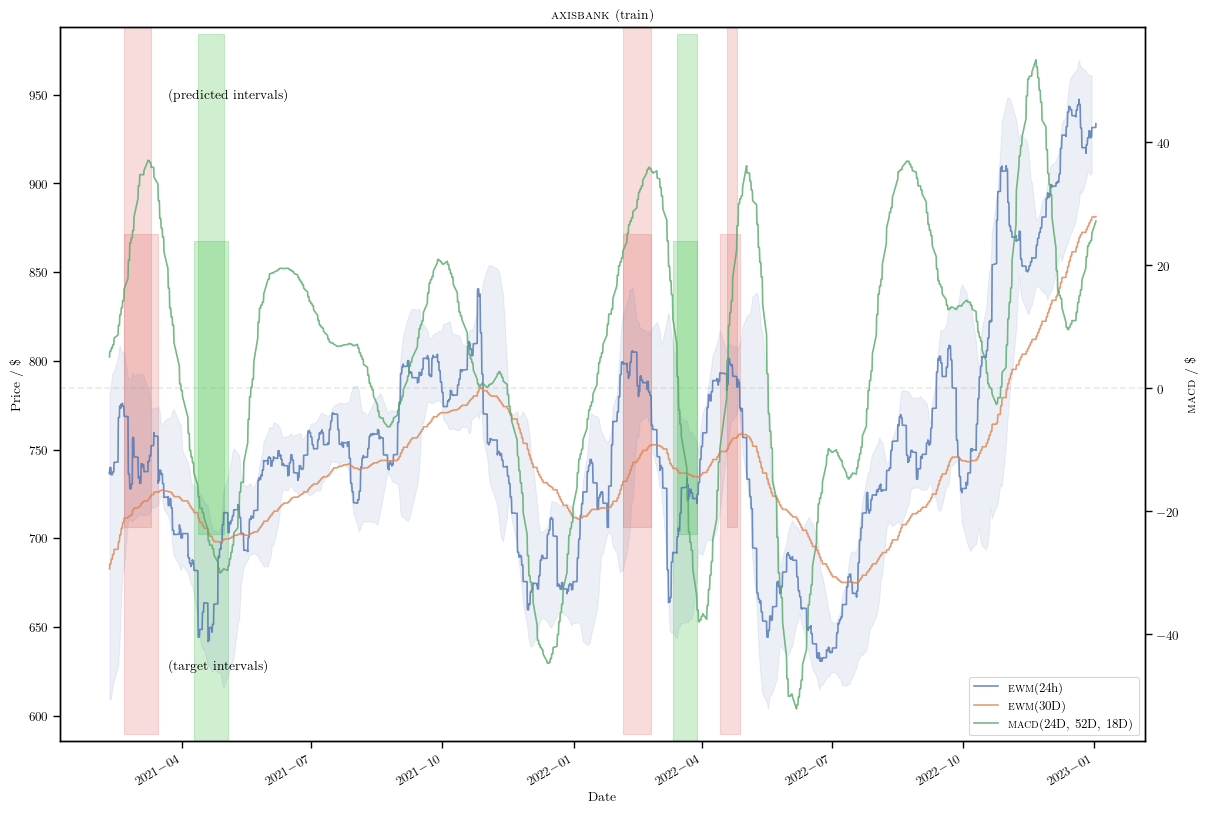

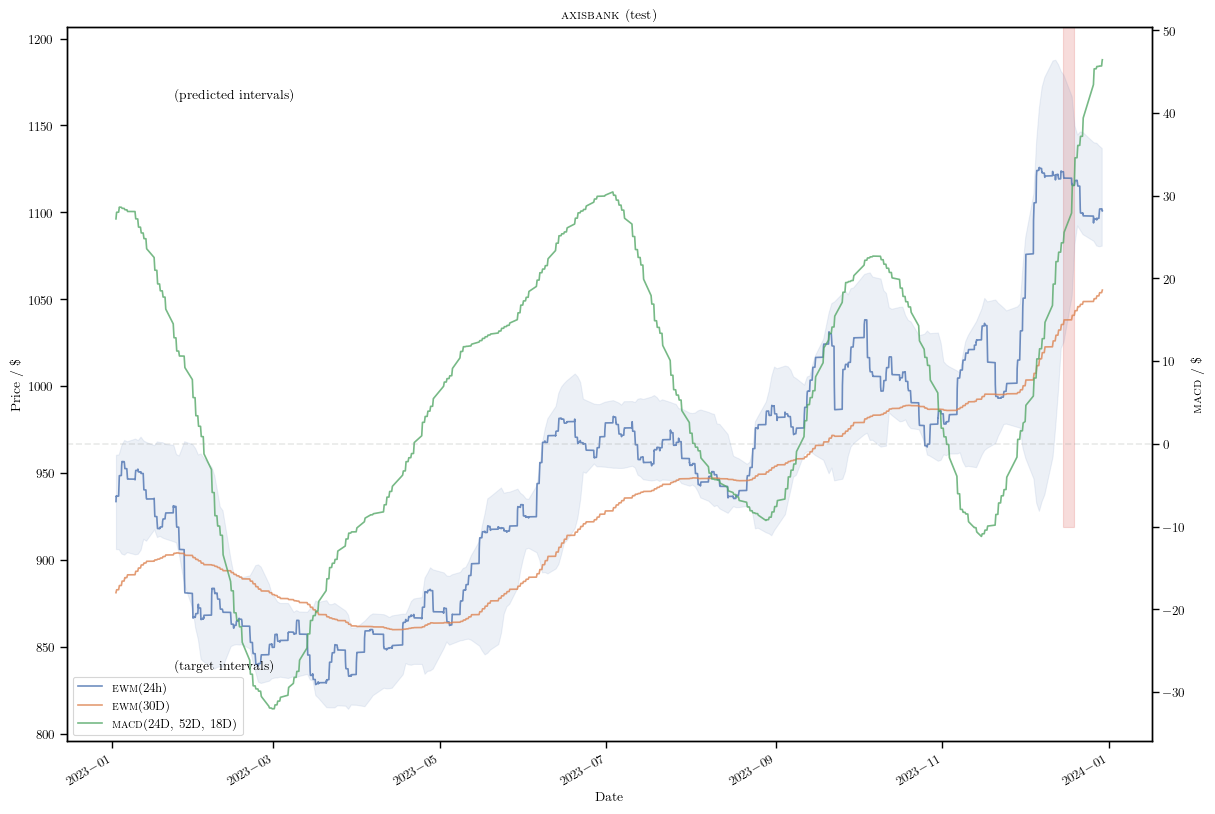

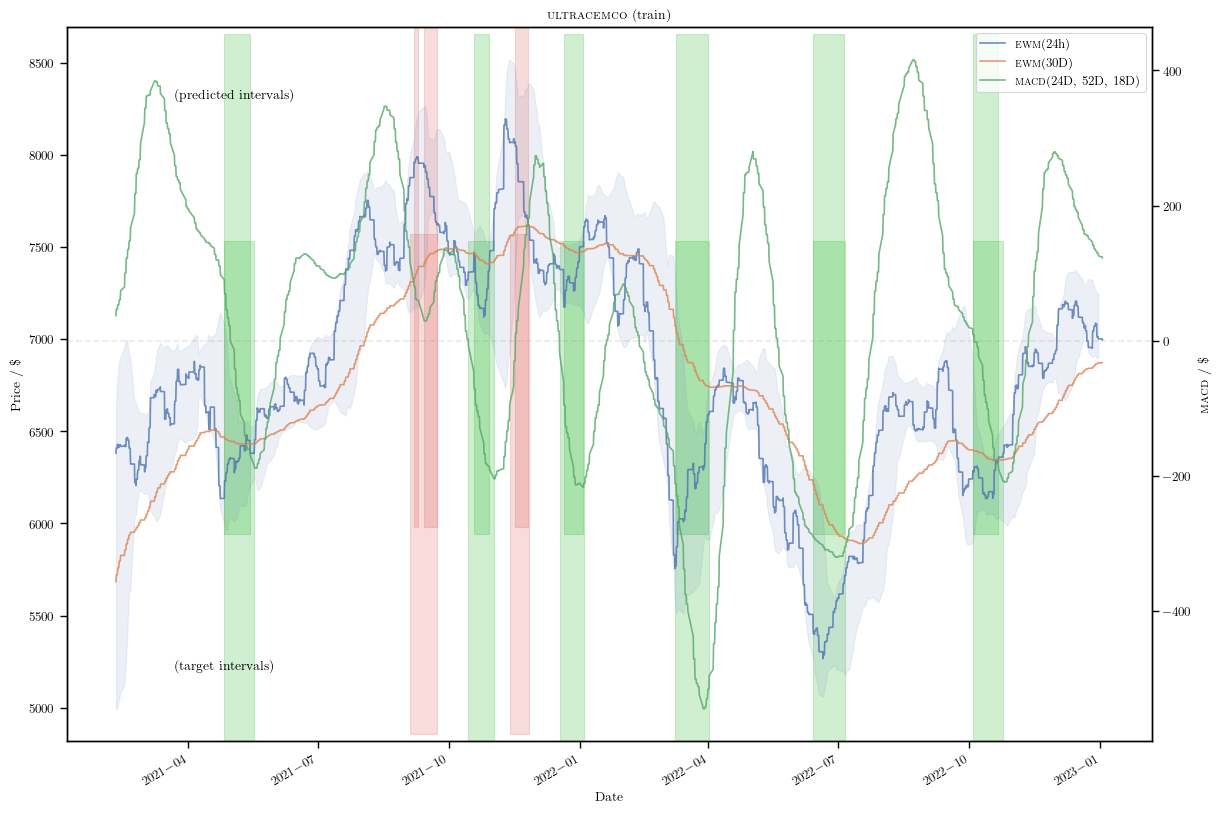

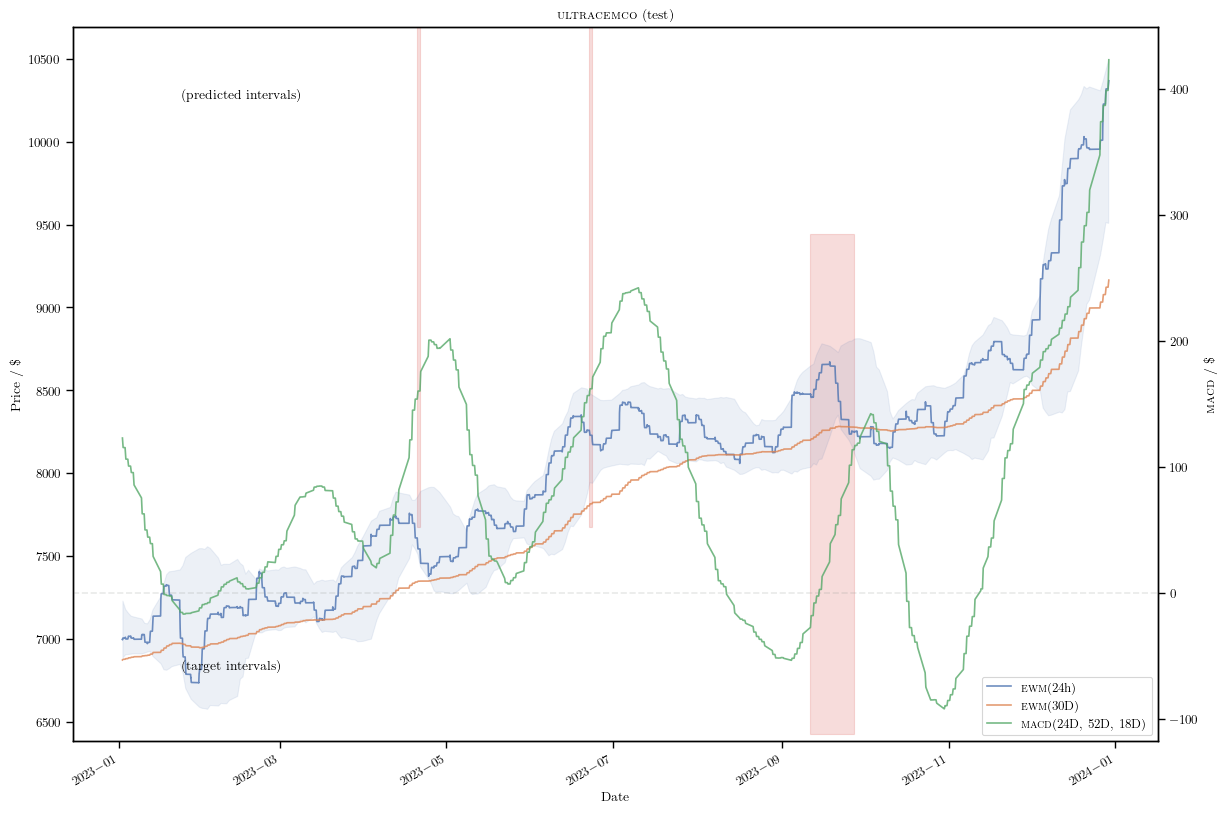

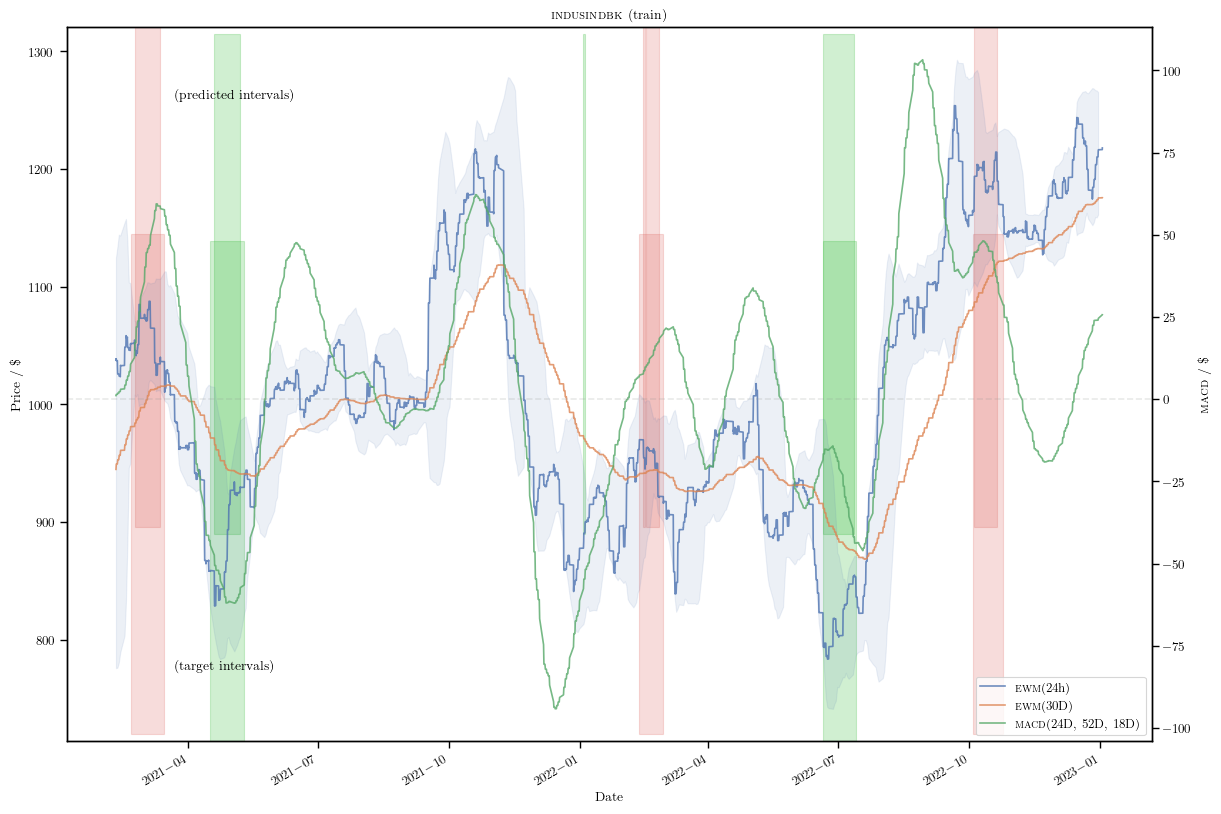

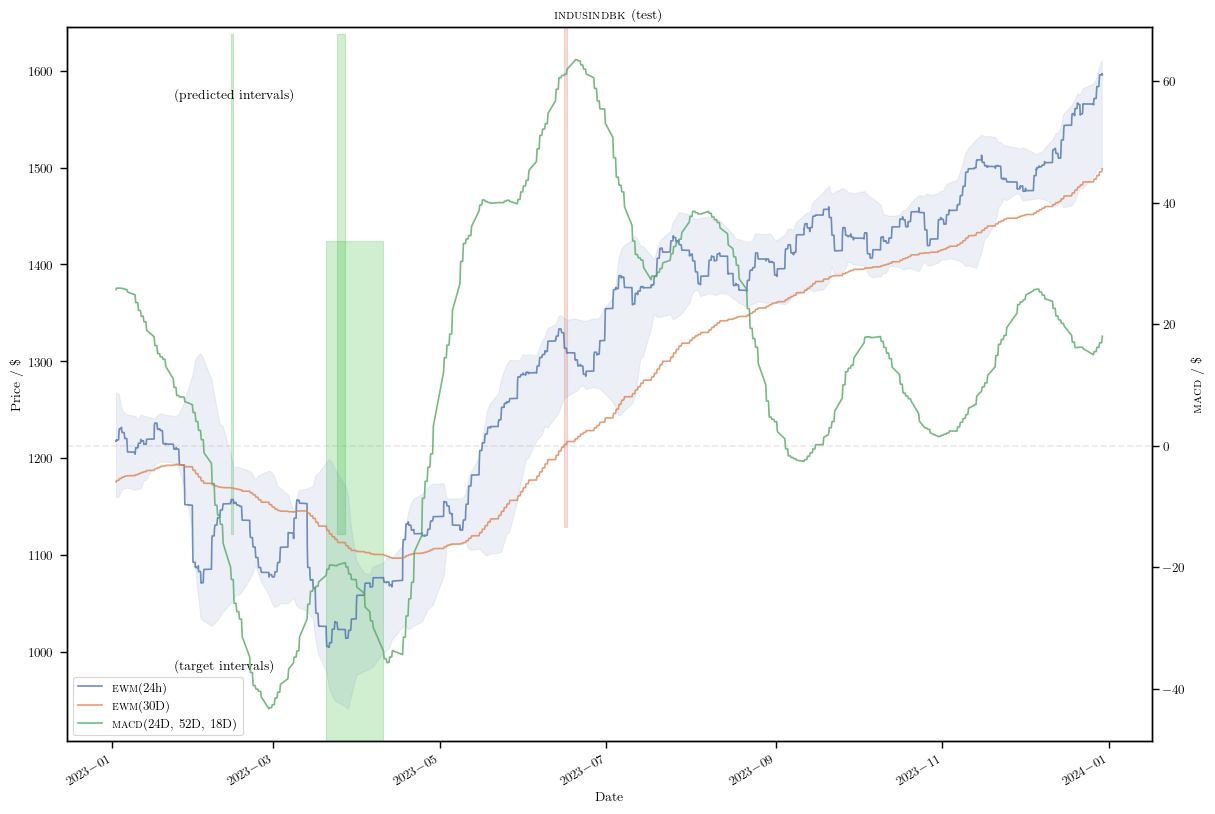

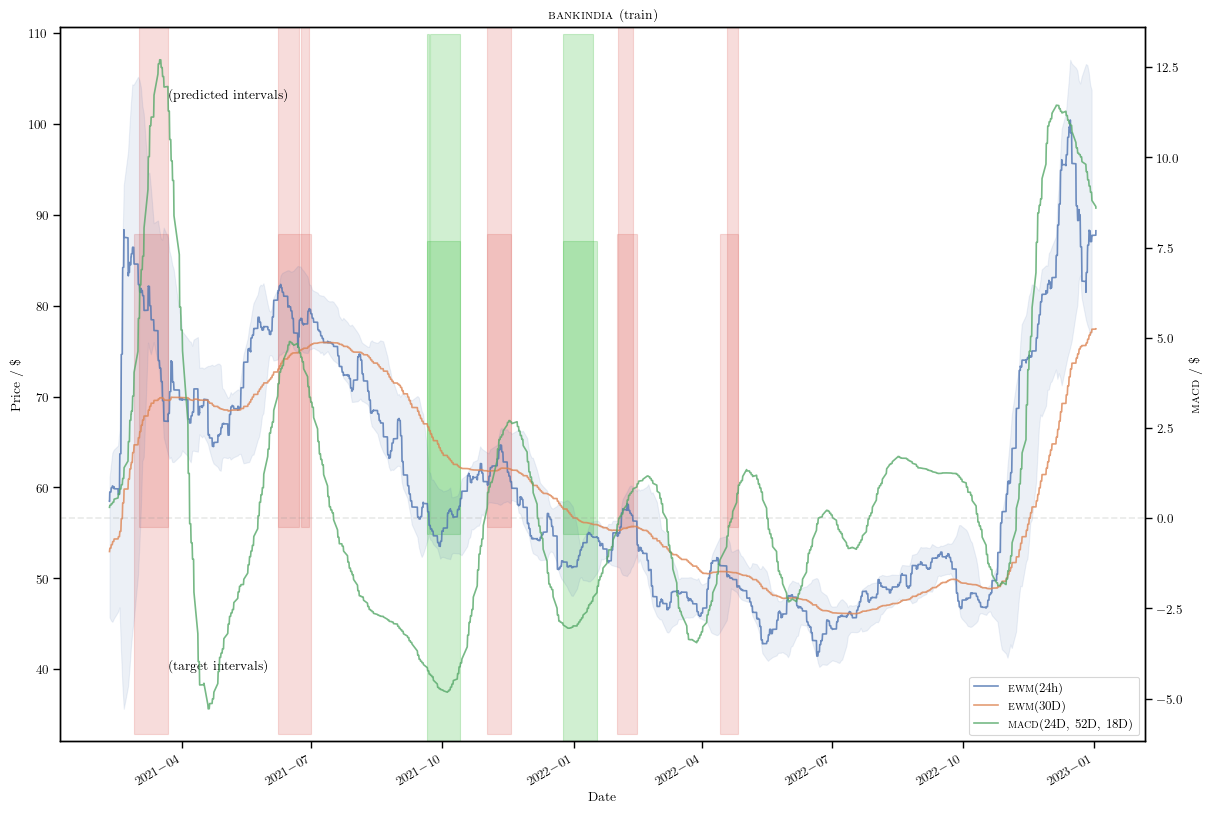

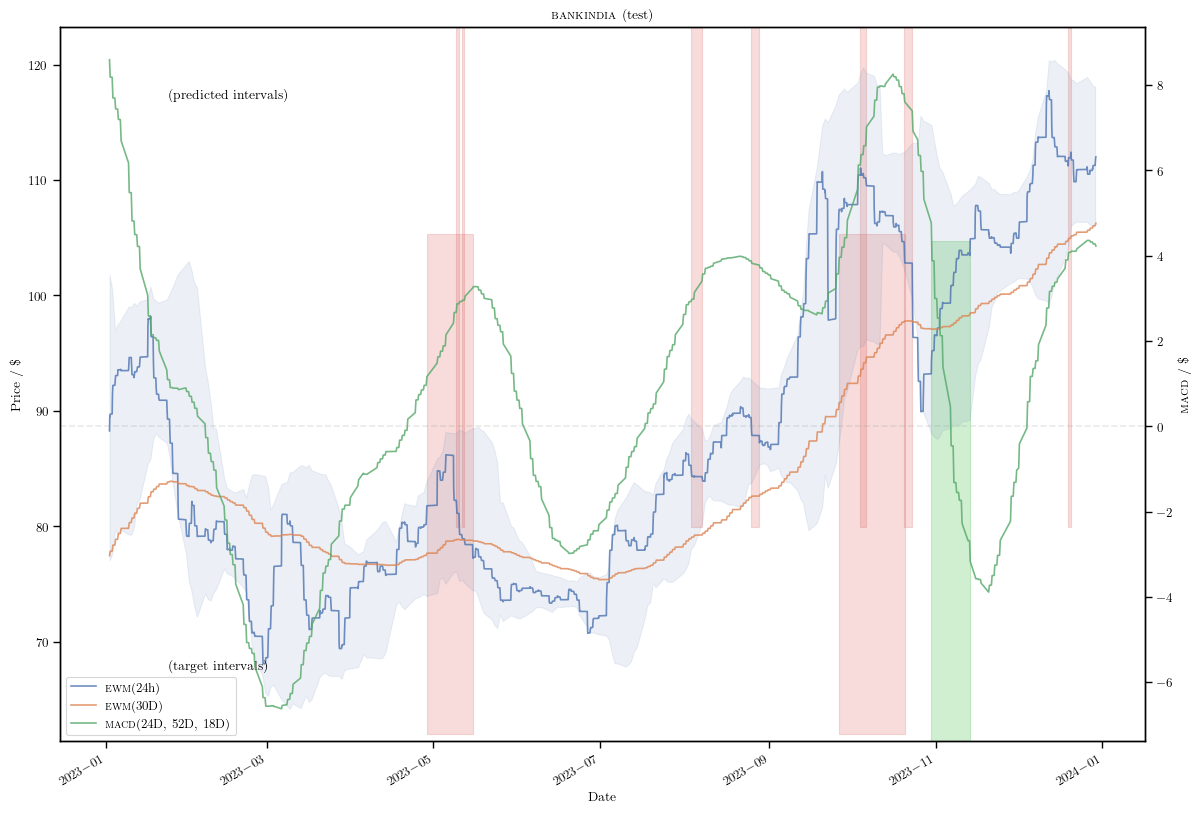

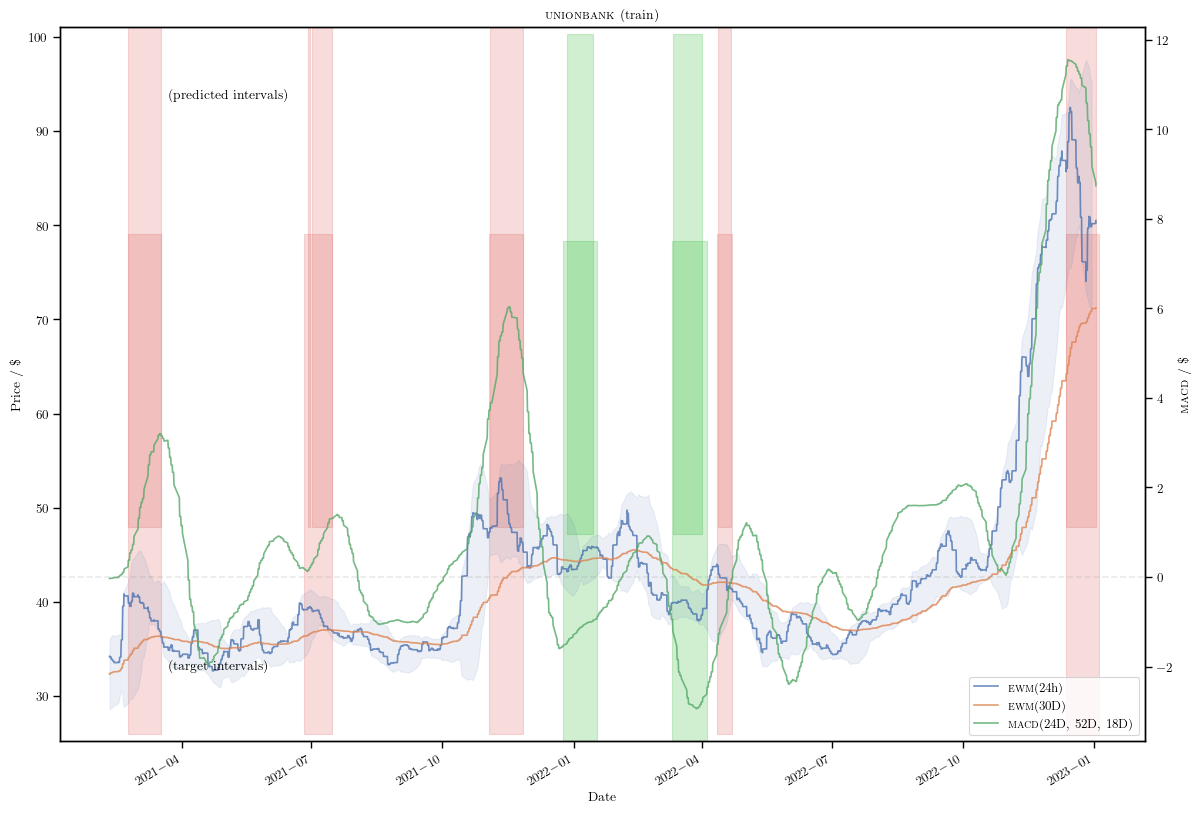

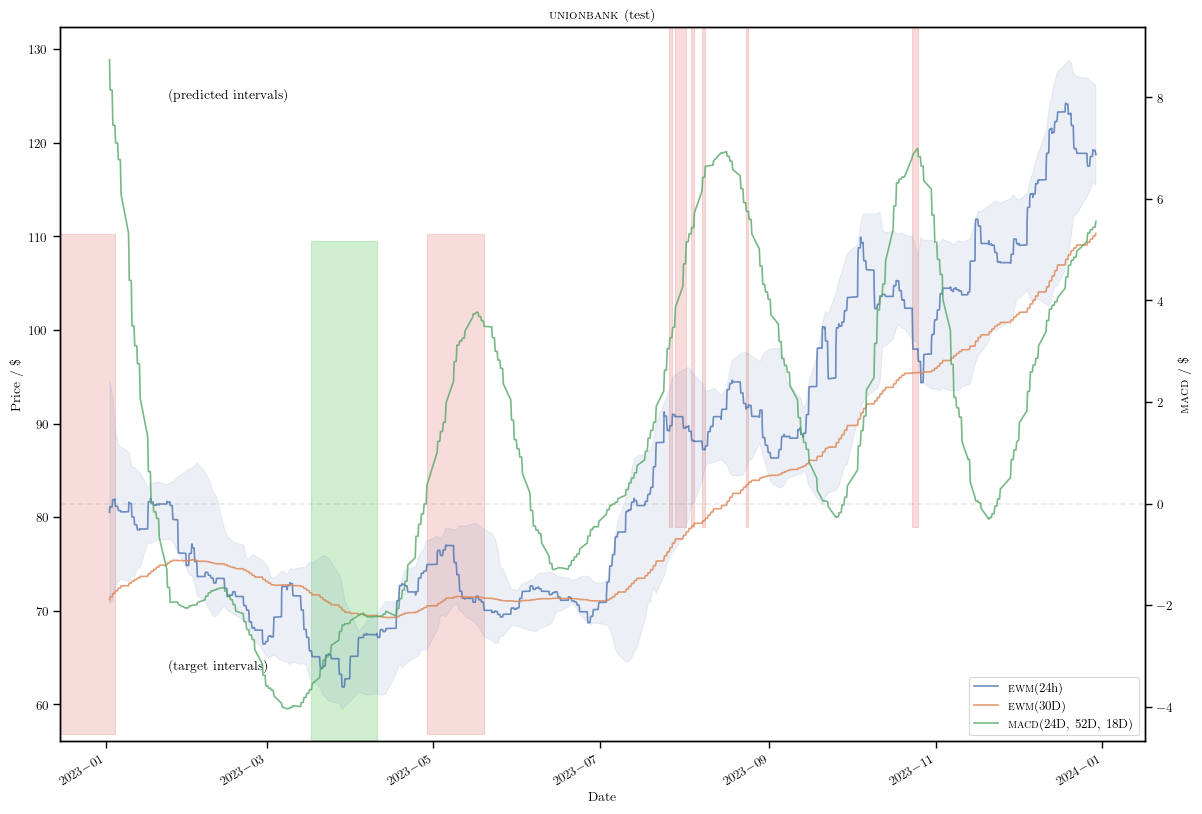

In [54]:
modelN = 6
for ticker in tickers[:modelN]:
    data = fetchTicker(ticker)
    sr = data["close"]
    sr.name = ticker
    srDaily = timeseriesAsOfTimestamps(sr, tradingDays)
    labelMap = {sr.name: latexTextSC(latexEscape(sr.name.lower()))}
    seriesPlots = [
        computeMultiple(
            computeEWM,
            sr,
            minPeriods=10,
            multipleArgs=[{"window": w} for w in ["24h", "30D"]],
            prettyLabelMap=labelMap,
        ),
        computeMACD(sr, short="24D", long="52D", ave="18D", prettyLabelMap=labelMap),
    ]
    bollinger, _ = computeBollingerBands(srDaily, prettyLabelMap=labelMap)
    labelMap = {k: v.removeprefix(labelMap[sr.name] + " ") for k, v in labelMap.items()}
    applyLabelMap(labelMap, seriesPlots + [bollinger])
    target = targetTrades.loc(axis=0)[ticker]
    for phase, idxs in zip(["train", "test"], next(testTimeCV.split()), strict=True):
        X = infData.X.iloc[idxs].loc(axis=0)[ticker, :]
        yPred = mapNumpyDataFrameToSeries(models[modelN].predict, X)
        fig = plotTimeseries(
            seriesPlots,
            [
                target[target["direction"] > THRESHOLD].index,  # type: ignore
                target[target["direction"] < -THRESHOLD].index,  # type: ignore
                coalesceIntervals(
                    yPred[yPred > THRESHOLD].index.get_level_values("time interval")
                ),
                coalesceIntervals(
                    yPred[yPred < -THRESHOLD].index.get_level_values("time interval")
                ),
            ],
            [bollinger],
            plotInterval=pd.Interval(
                X.index.get_level_values("time interval").left.min(),
                X.index.get_level_values("time interval").right.max(),
            ),
            figsize=(14, 10.5),  # (8, 4.8),
            title=f"{labelMap[ticker]} ({phase})",
            ylabels=[
                latexEscape("Price / $"),
                latexTextSC("macd") + latexEscape(" / $"),
            ],
            plotKWArgs={"alpha": 0.8},
            intervalColours=["xkcd:green", "xkcd:pale red"] * 2,
            intervalKWArgs=[
                {"ymin": 0, "ymax": 0.7},
                {"ymin": 0.01, "ymax": 0.71},
                {"ymin": 0.29, "ymax": 0.99},
                {"ymin": 0.3, "ymax": 1},
            ],
            bandColours=["C0"],
        )
        fig.axes[1].axhline(y=0, alpha=0.2, color="xkcd:grey", linestyle="--")
        fig.axes[0].annotate(
            "(predicted intervals)", (0.1, 0.9), xycoords="axes fraction"
        )
        fig.axes[0].annotate("(target intervals)", (0.1, 0.1), xycoords="axes fraction")
        del phase, idxs, X, yPred
    del sr, srDaily, labelMap, seriesPlots, bollinger, target, _
del modelN